---
# **Trabajo Final Machine Learning**

> ## *Estimador de precios de AirBnb*

---

> Realizado por: Ángel Sarriá Jiménez y Silvia Gamundi Sumando



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
#pip install plotly==5.13.1
import plotly.express as px
from sklearn.impute import KNNImputer
import scipy.stats as ss
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import pylab
from scipy.stats import shapiro
from sklearn.pipeline import Pipeline

In [ ]:
# df = pd.read_csv('/content/airbnb-listings-extract (2).csv',sep=';')
df = pd.read_csv('/content/drive/MyDrive/airbnb-listings-extract (2).csv',sep=';')
df.head()

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,11210388,https://www.airbnb.com/rooms/11210388,20170306202425,2017-03-07,The Loft-Full Bath-Deck w/View,Loft in the Hill country 12-15 minutes directl...,This loft has a spectacular view of the hills ...,Loft in the Hill country 12-15 minutes directl...,none,This neighborhood is located in the hills west...,...,10.0,10.0,10.0,NaN,NaN,moderate,1.0,3.50,"30.3373609355,-97.8632766782","Host Is Superhost,Host Has Profile Pic,Host Id..."
1,17471131,https://www.airbnb.com/rooms/17471131,20170407214050,2017-04-08,"Claris I, Friendly Rentals","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...",none,Plaza Cataluña Catalonia Square is the large...,...,10.0,8.0,10.0,HUTB-006721,NaN,super_strict_30,106.0,0.86,"41.3896829422,2.17262543017","Host Has Profile Pic,Requires License,Instant ..."
2,17584891,https://www.airbnb.com/rooms/17584891,20170407214050,2017-04-08,"Style Terrace Red, Friendly Rentals","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...",none,Plaza Cataluña Catalonia Square is the large...,...,NaN,NaN,NaN,HUTB-007527,NaN,super_strict_30,106.0,NaN,"41.3930345489,2.16217327868","Host Has Profile Pic,Requires License,Instant ..."
3,5398030,https://www.airbnb.com/rooms/5398030,20170407214050,2017-04-08,Picasso Suite 1.4 Paseo de Gracia,Live like a local in Barcelona's most chic dis...,You wake up to the sun rising over Barcelona's...,Live like a local in Barcelona's most chic dis...,none,We're right in the heart of the chic L'Eixampl...,...,10.0,10.0,9.0,NaN,NaN,strict,24.0,1.09,"41.3969668101,2.1674178103","Host Has Profile Pic,Host Identity Verified,Re..."
4,18104606,https://www.airbnb.com/rooms/18104606,20170407214050,2017-04-08,Smart City Centre Apartment II,"Unique apartment in vibrant neighborhoods, car...","License: HUTB-005313 Charming apartment, locat...","Unique apartment in vibrant neighborhoods, car...",none,NaN,...,NaN,NaN,NaN,NaN,NaN,flexible,92.0,NaN,"41.3886851936,2.15514963616","Host Has Profile Pic,Host Identity Verified,Is..."


# 1. ESTUDIO INICIAL DEL DATASET

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14780 entries, 0 to 14779
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              14780 non-null  int64  
 1   Listing Url                     14780 non-null  object 
 2   Scrape ID                       14780 non-null  int64  
 3   Last Scraped                    14780 non-null  object 
 4   Name                            14779 non-null  object 
 5   Summary                         14189 non-null  object 
 6   Space                           10888 non-null  object 
 7   Description                     14774 non-null  object 
 8   Experiences Offered             14780 non-null  object 
 9   Neighborhood Overview           9134 non-null   object 
 10  Notes                           5644 non-null   object 
 11  Transit                         9066 non-null   object 
 12  Access                          

Nuestra base de datos cuenta con 14780 observaciones y 89 variables. De todas ellas únicamente 36 son numéricas y el resto son object.

En primer lugar eliminaremos las variables que, a simple vista, no aportaran ningun tipo de informacion relevante al modelo (como ids y fechas), que tengan muy pocos datos (como *License* o *Jurisdiction Names*) o que contengan descripciones demasiado grandes como para poder procesarlas y extraer informacion relevante.

Tambien eliminaremos las avariables *Weekly Price* y *Monthly Price* ya que, a parte de contener muchos valores nulos, representa nuestra variable objetivo pero acumulada en distintos periodods de tiempo.

In [ ]:
df.drop(df.columns[[0,1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19,20,21,
                        23,24,27,28,29,30,34,35,36,37,40,43,55,57,58,66,71,73,74,82,
                        83,87]] , axis=1,inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14780 entries, 0 to 14779
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Experiences Offered             14780 non-null  object 
 1   Host Since                      14777 non-null  object 
 2   Host Response Time              12881 non-null  object 
 3   Host Response Rate              12881 non-null  float64
 4   Host Listings Count             14777 non-null  float64
 5   Host Total Listings Count       14777 non-null  float64
 6   Host Verifications              14774 non-null  object 
 7   City                            14774 non-null  object 
 8   State                           14636 non-null  object 
 9   Market                          14723 non-null  object 
 10  Smart Location                  14780 non-null  object 
 11  Country                         14779 non-null  object 
 12  Latitude                        

Finalmente nos quedaremos con estas 46 variables. Más adelante veremos si eliminamos o creamos algunas más.


## 1.1 Estudio, visualizacion y primeras decisiones


Estudiaremos en primer lugar el numero de valores unicos por variable, para ver cual de ellas es categorica y cuales no:

In [ ]:
df.nunique()

Experiences Offered                   5
Host Since                         2116
Host Response Time                    4
Host Response Rate                   70
Host Listings Count                  56
Host Total Listings Count            56
Host Verifications                  206
City                                246
State                               102
Market                               43
Smart Location                      257
Country                              17
Latitude                          14780
Longitude                         14780
Property Type                        22
Room Type                             3
Accommodates                         16
Bathrooms                            17
Bedrooms                             10
Beds                                 16
Bed Type                              5
Amenities                         12379
Price                               370
Security Deposit                    124
Cleaning Fee                        111


Veamos ahora los valores nulos por variable


In [ ]:
df.isnull().sum()

Experiences Offered                  0
Host Since                           3
Host Response Time                1899
Host Response Rate                1899
Host Listings Count                  3
Host Total Listings Count            3
Host Verifications                   6
City                                 6
State                              144
Market                              57
Smart Location                       0
Country                              1
Latitude                             0
Longitude                            0
Property Type                        0
Room Type                            0
Accommodates                         0
Bathrooms                           55
Bedrooms                            25
Beds                                49
Bed Type                             0
Amenities                          170
Price                               17
Security Deposit                  8524
Cleaning Fee                      6093
Guests Included          

Vemos que existen bastantes missings en muchas de las variables, estudiaremos cada una de ellas 1 a 1 para decidir el mejor tratamiento posible para los valores faltantes (en caso de necesitar imputacion).

Vamos a empezar con las variables que almacenan la ubicacion de los Airbnb:

In [ ]:
df['City'].value_counts().head(15)

Madrid         13207
Barcelona        292
London           132
Paris            108
马德里               52
Palma             49
Alcúdia           40
Dublin            40
Berlin            40
New York          38
Roma              37
Los Angeles       35
Brooklyn          27
Amsterdam         26
Wien              25
Name: City, dtype: int64

In [ ]:
df['State'].value_counts().head(15)

Comunidad de Madrid    10623
Community of Madrid     1887
Madrid                   677
Catalunya                187
Balearic Islands         176
Illes Balears            165
Île-de-France            107
NY                        70
CA                        64
England                   59
Catalonia                 59
Lazio                     55
马德里自治区                    49
Berlin                    40
Dublin                    38
Name: State, dtype: int64

In [ ]:
df['Market'].value_counts(dropna=False).head(15)

Madrid             13274
Mallorca Island      372
Barcelona            292
London               144
Paris                110
New York              70
NaN                   57
Rome                  55
Los Angeles           49
Dublin                45
Berlin                41
Sydney                36
Vienna                31
Amsterdam             26
Copenhagen            15
Name: Market, dtype: int64

In [ ]:
df['Smart Location'].value_counts().head(15)

Madrid, Spain             13194
Barcelona, Spain            290
London, United Kingdom      129
Paris, France               108
马德里, Spain                   52
Palma, Spain                 49
Alcúdia, Spain               40
Berlin, Germany              40
Dublin, Ireland              39
New York, NY                 38
Roma, Italy                  37
Los Angeles, CA              35
Amsterdam, Netherlands       26
Brooklyn, NY                 26
Wien, Austria                25
Name: Smart Location, dtype: int64

In [ ]:
df['Country'].value_counts(dropna=False).head(15)

Spain             14001
United States       184
United Kingdom      159
France              110
Italy                68
Australia            46
Ireland              45
Germany              41
Austria              31
Netherlands          26
Canada               20
Belgium              17
Denmark              16
Switzerland           6
Greece                5
Name: Country, dtype: int64

In [ ]:
#Los caracteres significan madrid, comunidad de madrid y españa en chino
#Los traducimos para que no de problemas a la hora de graficar
df.replace('马德里','Madrid',inplace=True)
df.replace('馬德里','Madrid',inplace=True) 
df.replace('马德里, Spain','Madrid, Spain',inplace=True)
df.replace('马德里自治区','Comunidad de Madrid',inplace=True) 
df.replace('馬德里自治區','Comunidad de Madrid',inplace=True)
df.replace('馬德里, Spain','Madrid, Spain',inplace=True)
df.replace('西班牙','Spain',inplace=True)                     

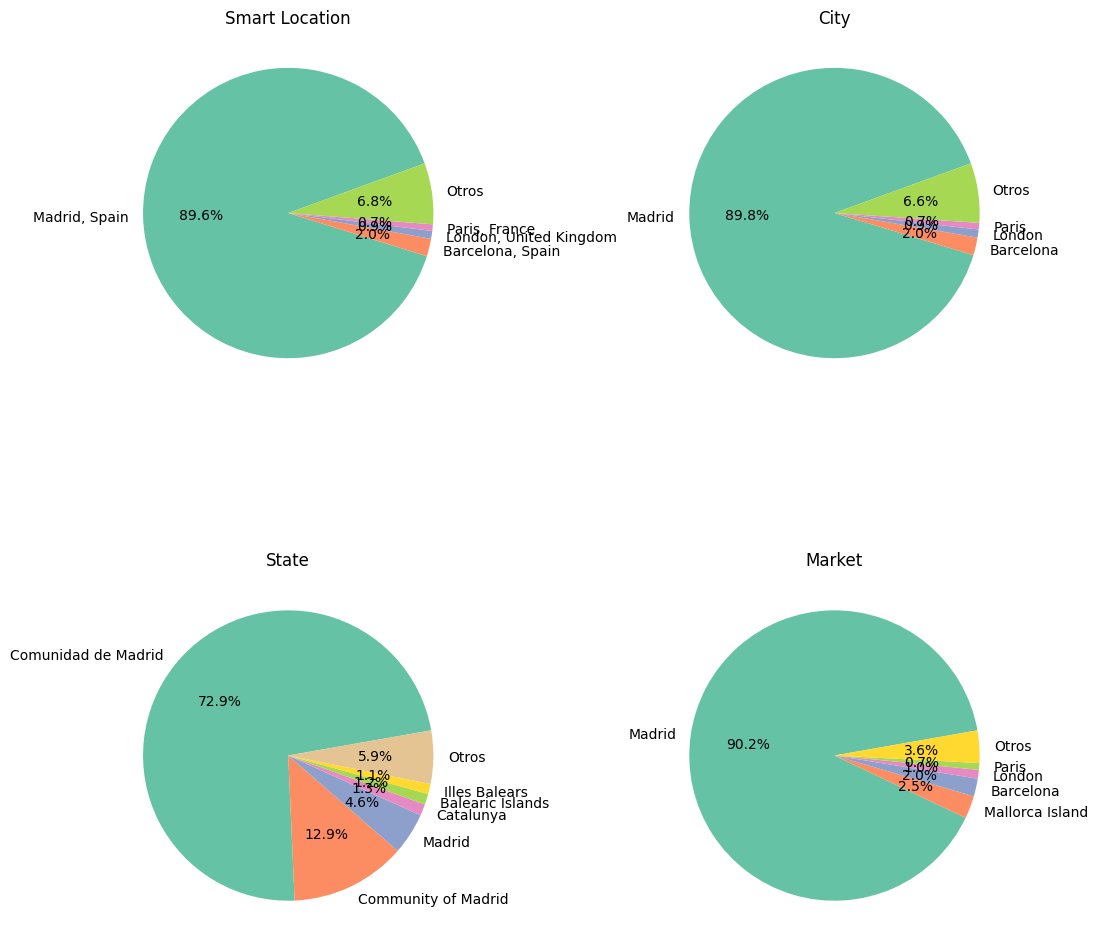

In [ ]:
# Datos para los pie charts

# Configuración de los subplots
fig, axs = plt.subplots(2, 2, figsize=(11, 11))

# Pie chart 1
# Datos de ejemplo con las categorías
categorias = df['Smart Location'].value_counts().index  

# Crear un DataFrame con las categorías
data = pd.DataFrame({'Categorías': categorias})

# Calcular la frecuencia de cada categoría
frecuencias = df['Smart Location'].value_counts()

# Número máximo de categorías individuales a mostrar (ejemplo: 10)
num_categorias_individuales = 4

# Categorías individuales
categorias_individuales = frecuencias[:num_categorias_individuales].index.tolist()

# Categorías para "Otros"
categorias_otros = frecuencias[num_categorias_individuales:].index.tolist()

# Calcular la frecuencia total para "Otros"
frecuencia_otros = frecuencias[num_categorias_individuales:].sum()

# Crear una nueva serie de frecuencias que incluya "Otros"
frecuencias_actualizadas = frecuencias[:num_categorias_individuales].append(pd.Series(frecuencia_otros, index=['Otros']))

# Configurar el pie chart

axs[0, 0].pie(frecuencias_actualizadas, labels=frecuencias_actualizadas.index, autopct='%1.1f%%', startangle=20,colors=sns.color_palette('Set2'))
axs[0, 0].set_title('Smart Location')

# Pie chart 2
# Datos de ejemplo con las categorías
categorias = df['City'].value_counts().index  

# Crear un DataFrame con las categorías
data = pd.DataFrame({'Categorías': categorias})

# Calcular la frecuencia de cada categoría
frecuencias = df['City'].value_counts()

# Número máximo de categorías individuales a mostrar (ejemplo: 10)
num_categorias_individuales = 4

# Categorías individuales
categorias_individuales = frecuencias[:num_categorias_individuales].index.tolist()

# Categorías para "Otros"
categorias_otros = frecuencias[num_categorias_individuales:].index.tolist()
# Calcular la frecuencia total para "Otros"
frecuencia_otros = frecuencias[num_categorias_individuales:].sum()

# Crear una nueva serie de frecuencias que incluya "Otros"
frecuencias_actualizadas = frecuencias[:num_categorias_individuales].append(pd.Series(frecuencia_otros, index=['Otros']))

# Configurar el pie chart

axs[0, 1].pie(frecuencias_actualizadas, labels=frecuencias_actualizadas.index, autopct='%1.1f%%', startangle=20,colors=sns.color_palette('Set2'))
axs[0, 1].set_title('City')

# Pie chart 3
# Datos de ejemplo con las categorías
categorias = df['State'].value_counts().index  

# Crear un DataFrame con las categorías
data = pd.DataFrame({'Categorías': categorias})

# Calcular la frecuencia de cada categoría
frecuencias = df['State'].value_counts()

# Número máximo de categorías individuales a mostrar (ejemplo: 10)
num_categorias_individuales = 6

# Categorías individuales
categorias_individuales = frecuencias[:num_categorias_individuales].index.tolist()

# Categorías para "Otros"
categorias_otros = frecuencias[num_categorias_individuales:].index.tolist()

# Calcular la frecuencia total para "Otros"
frecuencia_otros = frecuencias[num_categorias_individuales:].sum()

# Crear una nueva serie de frecuencias que incluya "Otros"
frecuencias_actualizadas = frecuencias[:num_categorias_individuales].append(pd.Series(frecuencia_otros, index=['Otros']))

# Configurar el pie chart

axs[1, 0].pie(frecuencias_actualizadas, labels=frecuencias_actualizadas.index, autopct='%1.1f%%', startangle=10,colors=sns.color_palette('Set2'))
axs[1, 0].set_title('State')

# Pie chart 4
# Datos de ejemplo con las categorías
categorias = df['Market'].value_counts().index  

# Crear un DataFrame con las categorías
data = pd.DataFrame({'Categorías': categorias})

# Calcular la frecuencia de cada categoría
frecuencias = df['Market'].value_counts()

# Número máximo de categorías individuales a mostrar (ejemplo: 10)
num_categorias_individuales = 5

# Categorías individuales
categorias_individuales = frecuencias[:num_categorias_individuales].index.tolist()

# Categorías para "Otros"
categorias_otros = frecuencias[num_categorias_individuales:].index.tolist()

# Calcular la frecuencia total para "Otros"
frecuencia_otros = frecuencias[num_categorias_individuales:].sum()

# Crear una nueva serie de frecuencias que incluya "Otros"
frecuencias_actualizadas = frecuencias[:num_categorias_individuales].append(pd.Series(frecuencia_otros, index=['Otros']))

# Configurar el pie chart

axs[1,1].pie(frecuencias_actualizadas, labels=frecuencias_actualizadas.index, autopct='%1.1f%%', startangle=10,colors=sns.color_palette('Set2'))
axs[1,1].set_title('Market')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar los gráficos
plt.show()


Vemos que las 4 variables almacenan la misma informacion. Sin embargo, vemos que *State*, *City* y *Smart Location* presentan problemas de introduccion de datos, ya que estan las mismas localizaciones en distintos idiomas. La variable *Market* no presenta este problema asi que nos quedaremos y con *Country* para proseguir con nuestro analisis.

In [ ]:
df.drop(['State','City','Smart Location'],axis=1,inplace=True)

Otra importante conclusion que podemos sacar de la visualizacion anterior es el desbalanceo de los datos, ya que un 90% de ellos tienen ubicacion en Madrid (94% en España) y solo alrededor de un 6% en el resto del mundo. Podria ser interesante quedarnos unicamente con las observaciones de España para que el 6% restante no interfiera en la prediccion y nuestros datos se vuelvan homogeneos en cuanto a la localizacion.

Sigamos con el estudio del resto de variables con *Host Response Time* y *Host Response Rate*:

In [ ]:
df.loc[:,['Host Response Time','Host Response Rate']].tail(20)

,Host Response Time,Host Response Rate
14760,NaN,NaN
14761,within an hour,98.0
14762,NaN,NaN
14763,within an hour,100.0
14764,within an hour,97.0
14765,within a day,96.0
14766,within a few hours,100.0
14767,within an hour,97.0
14768,within an hour,100.0
14769,within an hour,97.0


In [ ]:
df['Host Response Time'].value_counts(dropna=False)

within an hour        7905
within a few hours    2872
NaN                   1899
within a day          1802
a few days or more     302
Name: Host Response Time, dtype: int64

In [ ]:
df['Host Response Rate'].value_counts(dropna=False)

100.0    9670
NaN      1899
90.0      340
96.0      297
99.0      260
         ... 
54.0        1
14.0        1
41.0        1
59.0        1
24.0        1
Name: Host Response Rate, Length: 71, dtype: int64

Vemos que *Host Response Time* y *Host Response Rate* presenta la misma informacion.
Puesto que es más facil de interpretar y manejar una variable numerica que una categorica, nos quedaremos con *Host Response Rate*.

In [ ]:
df.drop(['Host Response Time'],axis=1,inplace=True)

Vemos si las columnas Host Listings Count y Host Total Listings Count son la misma columna:

In [ ]:
print(df['Host Listings Count'].equals(df['Host Total Listings Count'])) #son la misma!
#Eliminaremos una de ellas

True


In [ ]:
df.drop(['Host Listings Count'],axis=1,inplace=True)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Host Response Rate,12881.0,94.823461,15.215988,0.000000,100.000000,100.000000,100.000000,100.000000
Host Total Listings Count,14777.0,12.513636,34.090223,0.000000,1.000000,2.000000,6.000000,519.000000
Latitude,14780.0,40.497626,4.641387,-37.851182,40.409726,40.419466,40.430916,55.966912
Longitude,14780.0,-3.858041,14.123146,-123.131344,-3.707604,-3.700785,-3.684057,153.371427
Accommodates,14780.0,3.277808,2.097291,1.000000,2.000000,3.000000,4.000000,16.000000
Bathrooms,14725.0,1.281732,0.658517,0.000000,1.000000,1.000000,1.000000,8.000000
Bedrooms,14755.0,1.343816,0.900078,0.000000,1.000000,1.000000,2.000000,10.000000
Beds,14731.0,2.044260,1.612770,1.000000,1.000000,2.000000,2.000000,16.000000
Price,14763.0,73.561471,72.062050,9.000000,34.000000,55.000000,86.000000,999.000000
Security Deposit,6256.0,189.226822,115.151070,0.000000,100.000000,150.000000,200.000000,990.000000


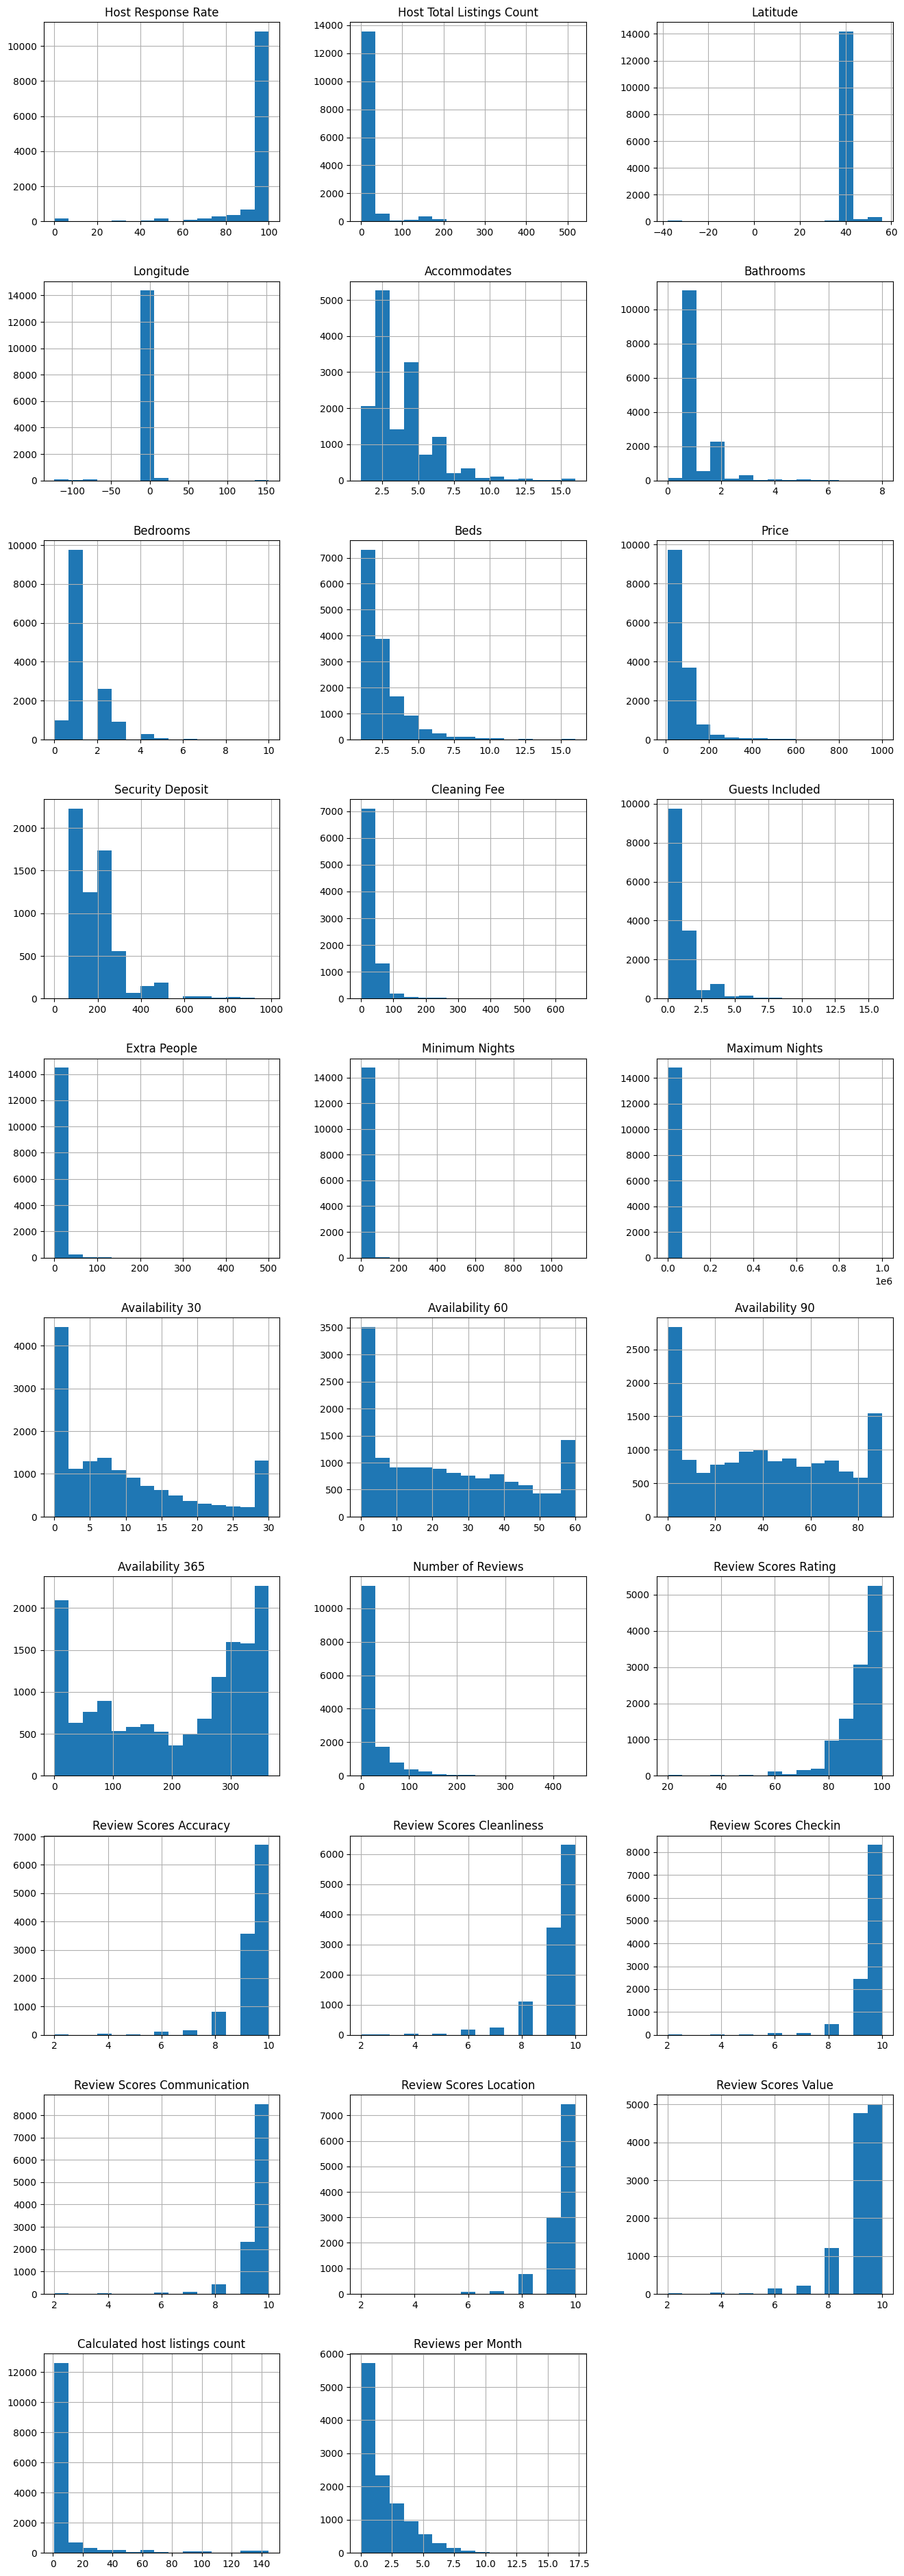

In [ ]:
df.hist(figsize=(16,48),layout=(10,3),bins=15)
plt.show()

Se puede observar que la información que proporcionan las variables Review Scores Accuracy, Review Scores Cleanliness, Review Scores Checkin, Review Scores Communication, Review Scores Location, Review Scores Value vienen recogidas en la variable Review Scores Rating, lo que se puede apreciar en los gráficos anteriores. Esta última variable proporciona una puntuación global del 1 al 100, con lo cual procederemos a eliminar las variables que hemos mencionado al principio.

In [ ]:
df.drop(['Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Location', 'Review Scores Value'],axis=1,inplace=True)

Vamos a visualizar en un mapa las localizaciones de los distintos apartamentos con las variables *Latitude* y *Longitude*. Posteriormente a la visualizacion, veremos si las eliminaremos ya que, a priori, aportan la misma informacion que las variables *Country* o *Market*.

In [ ]:
#Mapa de la ubicacion de las propiedades
fig = px.scatter_mapbox(df, 
                        lat="Latitude", 
                        lon="Longitude", 
                        )

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Interactuando con el mapa, vemos que la informacion que nos da corresponde a la antes vista en las variables country y market y en los graficos de tarta. La amplisima mayoria de observaciones se localizan en madrid, aunque tenemos airbnbs repartidos por todo el mundo. En el caso de Madrid, se observa especial densidad en la zona central, sobretodo en el distrito Centro, formado por los barrios de Embajadores, Sol, Cortes, Justicia, Universidad y Palacio. Esto tiene sentido ya que es la zona más turistica de Madrid.

## 1.2 Transformacion de variables

#### - Host Since

Transformaremos la variable *Host Since* por los años que lleva siendo Host para que sea numérica.

In [ ]:
df['Host Since'] = pd.to_datetime(df['Host Since'])
df['Host Since']=df['Host Since'].apply(lambda x: 2023-x.year)

In [ ]:
df['Host Since'].value_counts(dropna=False)

8.0     3360
7.0     3231
9.0     2654
10.0    2111
11.0    1900
6.0      719
12.0     629
13.0     164
14.0       9
NaN        3
Name: Host Since, dtype: int64

#### - Host Verifcations

Creamos una columna nueva que almacena el numero de verificaciones que tiene un perfil y ademas imputamos los missing de la variable *Host Verifications* por 0


In [ ]:
def Num_Verificaciones(df):
  df['Num_Verificaciones']= 0
  df['Host Verifications'].fillna(0,inplace=True) #Si es missing es porque no tiene 'Amenities'
  for x in range(len(df['Host Verifications'])):
    try:
      df.loc[x,'Num_Verificaciones'] = len(df.loc[x,'Host Verifications'].split(','))
    except:
      pass

#### - Amenities

Hacemos lo mismo para *Amenities*

In [ ]:
def Num_Amenities(df):
  df['Num_Amenities']= 0
  df['Amenities'].fillna(0,inplace=True) #Si es missing es porque no tiene 'Amenities'
  for x in range(len(df['Amenities'])):
    try:
      df.loc[x,'Num_Amenities'] = len(df.loc[x,'Amenities'].split(','))
    except:
      pass

In [ ]:
Num_Amenities(df)
Num_Verificaciones(df)
df.drop(['Amenities','Host Verifications'],axis=1,inplace=True)

#### - Features

Vamos a crear una columna por cada valor distinto de la columna *Features*

In [ ]:
df.Features.fillna('Nada',inplace= True)

In [ ]:
max(df['Features'].str.split(',').apply(len))

8

In [ ]:
df[['A','B','C','D','E','F','G','H']] = df['Features'].str.split(',', 8, expand=True)

In [ ]:
df.loc[233,['A','B','C','D','E','F','G','H']] #Estas son todas las features

A                   Host Is Superhost
B                Host Has Profile Pic
C              Host Identity Verified
D                   Is Location Exact
E                    Requires License
F                    Instant Bookable
G       Require Guest Profile Picture
H    Require Guest Phone Verification
Name: 233, dtype: object

In [ ]:
#Columna Host is superhost
df_temp=df.loc[:,['A']]== 'Host Is Superhost'
df['Host Is Superhost']=df_temp.astype('int')

In [ ]:
#Columna Host has profile pic
df_temp=df.loc[:,['A','B','C','D','E','F','G','H']]== 'Host Has Profile Pic'
df['Host Has Profile Pic']=df_temp.sum(axis=1)

In [ ]:
#Columna Host Identity Verified
df_temp=df.loc[:,['A','B','C','D','E','F','G','H']]== 'Host Identity Verified'
df['Host Identity Verified']=df_temp.sum(axis=1)

In [ ]:
#Columna Is Location Exact
df_temp=df.loc[:,['A','B','C','D','E','F','G','H']]== 'Is Location Exact'
df['Is Location Exact']=df_temp.sum(axis=1)

In [ ]:
#Columna 'Requires License'
df_temp=df.loc[:,['A','B','C','D','E','F','G','H']]== 'Requires License'
df['Requires License']=df_temp.sum(axis=1)

In [ ]:
#Columna Instant Bookable
df_temp=df.loc[:,['A','B','C','D','E','F','G','H']]== 'Instant Bookable'
df['Instant Bookable']=df_temp.sum(axis=1)

In [ ]:
#Columna Require Guest Profile Picture
df_temp=df.loc[:,['A','B','C','D','E','F','G','H']]== 'Require Guest Profile Picture'
df['Require Guest Profile Picture']=df_temp.sum(axis=1)

In [ ]:
#Columna Require Guest Phone Verification
df_temp=df.loc[:,['A','B','C','D','E','F','G','H']]== 'Require Guest Phone Verification'
df['Require Guest Phone Verification']=df_temp.sum(axis=1)

In [ ]:
df.drop(['A','B','C','D','E','F','G','H'],axis=1,inplace=True)

In [ ]:
df.drop(['Features'],axis=1,inplace=True)

In [ ]:
df.head()

,Experiences Offered,Host Since,Host Response Rate,Host Total Listings Count,Market,Country,Latitude,Longitude,Property Type,Room Type,...,Num_Amenities,Num_Verificaciones,Host Is Superhost,Host Has Profile Pic,Host Identity Verified,Is Location Exact,Requires License,Instant Bookable,Require Guest Profile Picture,Require Guest Phone Verification
0,none,7.0,100.0,1.0,Austin,United States,30.337361,-97.863277,Loft,Entire home/apt,...,23,4,1,1,1,1,0,0,0,0
1,none,7.0,100.0,162.0,Barcelona,Spain,41.389683,2.172625,Apartment,Entire home/apt,...,7,4,0,1,0,0,1,1,0,0
2,none,7.0,100.0,162.0,Barcelona,Spain,41.393035,2.162173,Apartment,Entire home/apt,...,7,4,0,1,0,0,1,1,0,0
3,none,13.0,100.0,27.0,Barcelona,Spain,41.396967,2.167418,Apartment,Entire home/apt,...,24,7,0,1,1,0,1,1,0,0
4,none,7.0,99.0,207.0,Barcelona,Spain,41.388685,2.155150,Apartment,Entire home/apt,...,12,4,0,1,1,1,1,1,0,0


## 1.3 Imputacion de valores missing

Recordamos que variables presentan missings:

In [ ]:
df.isna().sum()

Experiences Offered                    0
Host Since                             3
Host Response Rate                  1899
Host Total Listings Count              3
Market                                57
Country                                1
Latitude                               0
Longitude                              0
Property Type                          0
Room Type                              0
Accommodates                           0
Bathrooms                             55
Bedrooms                              25
Beds                                  49
Bed Type                               0
Price                                 17
Security Deposit                    8524
Cleaning Fee                        6093
Guests Included                        0
Extra People                           0
Minimum Nights                         0
Maximum Nights                         0
Calendar Updated                       0
Availability 30                        0
Availability 60 

Para la variable *Price* eliminaremos las observaciones con valores faltantes ya que es nuestra variable objetivo y estamos en un problema de aprendizaje supervisado. ¡Si no tenemos el valor de la variable objetivo no hay supervision!

In [ ]:
#Quitamos valores missing de la variable Price
df.dropna(subset=['Price'],inplace=True)
df.reset_index(drop=True,inplace=True)

In [ ]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,14753,14754,14755,14756,14757,14758,14759,14760,14761,14762
Experiences Offered,none,none,none,none,none,none,none,none,none,none,...,none,none,none,none,none,none,none,none,none,none
Host Since,7.0,7.0,7.0,13.0,7.0,7.0,10.0,11.0,7.0,8.0,...,6.0,9.0,10.0,10.0,12.0,10.0,6.0,8.0,10.0,9.0
Host Response Rate,100.0,100.0,100.0,100.0,99.0,99.0,100.0,100.0,99.0,100.0,...,100.0,33.0,96.0,96.0,NaN,100.0,NaN,100.0,100.0,100.0
Host Total Listings Count,1.0,162.0,162.0,27.0,207.0,207.0,2.0,1.0,207.0,1.0,...,1.0,3.0,147.0,147.0,1.0,1.0,1.0,1.0,1.0,1.0
Market,Austin,Barcelona,Barcelona,Barcelona,Barcelona,Barcelona,Barcelona,Barcelona,Barcelona,Austin,...,Mallorca Island,Mallorca Island,Mallorca Island,Mallorca Island,New York,New York,Paris,Paris,Denver,Seattle
Country,United States,Spain,Spain,Spain,Spain,Spain,Spain,Spain,Spain,United States,...,Spain,Spain,Spain,Spain,United States,United States,France,France,United States,United States
Latitude,30.337361,41.389683,41.393035,41.396967,41.388685,41.382537,41.399058,41.402357,41.407356,30.287124,...,39.646497,39.595354,39.604911,39.740432,40.771787,40.678945,48.836197,48.888809,39.742205,47.672327
Longitude,-97.863277,2.172625,2.162173,2.167418,2.15515,2.149577,2.184229,2.171119,2.182982,-97.768164,...,2.992312,2.927612,3.097125,2.931212,-73.898799,-73.939342,2.294045,2.316173,-104.959933,-122.291451
Property Type,Loft,Apartment,Apartment,Apartment,Apartment,Apartment,Apartment,Apartment,Apartment,House,...,House,House,House,House,Apartment,Apartment,Bed & Breakfast,Apartment,Apartment,House
Room Type,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt,Private room,Entire home/apt,Entire home/apt,...,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt,Private room,Entire home/apt,Private room,Entire home/apt,Entire home/apt,Private room


Veamos los missing para la variable *Market*, para su imputacion nos ayudaremos de las variables *Country* , *Latitude* y *Longitude*.

In [ ]:
np.where(df.Market.isna()==True) #Localizamos los missing

(array([  110,   410,   801,   907,   908,   938,  1278,  1355,  1470,
         1515,  1831,  2146,  2412,  2563,  2726,  3043,  3044,  3394,
         3406,  3602,  4395,  4547,  4905,  5627,  6008,  6416,  6425,
         6638,  6982,  7969,  7983,  8043,  8200,  8447,  8957,  8988,
         9303,  9490,  9917,  9928, 10141, 10258, 10577, 10861, 10873,
        10933, 10938, 11192, 11627, 12737, 12784, 13137, 13252, 13253,
        13761, 13852, 14627]),)

In [ ]:
df.loc[[110,  410,  801,  907,  908,  938, 1278, 1355, 1470, 1515, 1831,
        2146, 2412, 2563, 2726, 3043, 3044,3394,
         3406,  3602,  4395,  4547,  4905,  5627,  6008,  6416,  6425,
         6638,  6982,  7969,  7983,  8043,  8200,  8447,  8957,  8988,
         9303,  9490,  9917,  9928, 10141, 10258, 10577, 10861, 10873,
        10933, 10938, 11192, 11627, 12737, 12784, 13137, 13252, 13253,
        13761, 13852, 14627],['Market','Country','Latitude','Longitude']]

,Market,Country,Latitude,Longitude
110,NaN,Spain,40.420503,-3.716370
410,NaN,Spain,40.411880,-3.695562
801,NaN,United Kingdom,51.512403,-0.272601
907,NaN,Spain,40.412363,-3.693803
908,NaN,Spain,40.410992,-3.695050
938,NaN,Spain,40.411115,-3.694278
1278,NaN,Spain,40.456450,-3.714141
1355,NaN,United Kingdom,51.573877,-0.096693
1470,NaN,Spain,40.412021,-3.695889
1515,NaN,Spain,40.423940,-3.704946


Fijandonos en las coordenadas y los paises, todos los missing corresponden con Madrid, excepto unos casos especiales que corresponde a otros paises. Imputamos estos ultimos a dedo y los demás con la funcion **_pd.DataFrame.fillna()_**

In [ ]:
df.loc[[801,1355 ],'Market']= 'London'
df.loc[[1831],'Market']= 'Athens'
df.loc[[4905],'Market']= 'Copenhagen'
df.loc[[4395],'Market']= 'San Diego'
df.loc[[13137],'Market']= 'Paris'
df.loc[[13761],'Market']= 'Geneva'

df.Market.fillna('Madrid',inplace=True)

In [ ]:
print(np.where(df.Country.isna()==True))

(array([151]),)


In [ ]:
df.loc[151,['Market','Country','Latitude','Longitude']]

Market          Madrid
Country            NaN
Latitude     40.476713
Longitude     -3.57189
Name: 151, dtype: object

De la misma forma que antes, el missing de la variable *Country* tiene como valor en *Market* Madrid, por lo que imputaremos el valor 'Spain'.

In [ ]:
df.loc[151,'Country']= 'Spain'

In [ ]:
df.isna().sum()

Experiences Offered                    0
Host Since                             3
Host Response Rate                  1896
Host Total Listings Count              3
Market                                 0
Country                                0
Latitude                               0
Longitude                              0
Property Type                          0
Room Type                              0
Accommodates                           0
Bathrooms                             54
Bedrooms                              25
Beds                                  48
Bed Type                               0
Price                                  0
Security Deposit                    8509
Cleaning Fee                        6085
Guests Included                        0
Extra People                           0
Minimum Nights                         0
Maximum Nights                         0
Calendar Updated                       0
Availability 30                        0
Availability 60 

#### - Host Response Rate y Host Total Listings Count

In [ ]:
df['Host Response Rate'].describe()

count    12867.000000
mean        94.845885
std         15.161008
min          0.000000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: Host Response Rate, dtype: float64

Tras ver los estadísticos descriptivos de la variable Host Response Rate vemos que la media es un valor adecuado para imputar los missings.

In [ ]:
df['Host Response Rate'].fillna(df['Host Response Rate'].mean(), inplace=True)

In [ ]:
df['Host Total Listings Count'].describe()

count    14760.000000
mean        12.523645
std         34.108196
min          0.000000
25%          1.000000
50%          2.000000
75%          6.000000
max        519.000000
Name: Host Total Listings Count, dtype: float64

In [ ]:
df['Calculated host listings count'].describe()

count    14759.000000
mean         9.493936
std         23.638296
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        145.000000
Name: Calculated host listings count, dtype: float64

Sin embargo, para *Host Total Listings Count* y *Calculated host listings count* no ocurre lo mismo. De todas maneras al tener solo tres y cuatro valores faltantes procederemos a eliminarlos debido al número elevado de observaciones en nuestro conjunto de datos.

In [ ]:
df.dropna(subset=['Host Total Listings Count'],inplace=True)
df.dropna(subset=['Calculated host listings count'], inplace=True)
df.reset_index(drop=True,inplace=True)

#### - Knn Imputer

In [ ]:
df['Review Scores Rating'].describe()

count    11463.000000
mean        91.695280
std          8.991274
min         20.000000
25%         89.000000
50%         94.000000
75%         98.000000
max        100.000000
Name: Review Scores Rating, dtype: float64

In [ ]:
df['Bathrooms'].describe()

count    14702.000000
mean         1.280472
std          0.654877
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: Bathrooms, dtype: float64

In [ ]:
df['Bedrooms'].describe()

count    14731.000000
mean         1.342407
std          0.897114
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         10.000000
Name: Bedrooms, dtype: float64

In [ ]:
df['Beds'].describe()

count    14708.000000
mean         2.042562
std          1.608169
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         16.000000
Name: Beds, dtype: float64

Tras observar los estadísticos decriptivos de Bedrooms, Bathrooms, Beds y Review Scores Rating cocluimos que la media no sería adecuada para imputar los missings de las variables debido a como estan distribuidos sus valores. Para obtener valores más adecuados usaremos el método KNNimputer. Redondearemos el resultado debido a que las tres variables presentan valores enteros.

In [ ]:
df.tail()

,Experiences Offered,Host Since,Host Response Rate,Host Total Listings Count,Market,Country,Latitude,Longitude,Property Type,Room Type,...,Num_Amenities,Num_Verificaciones,Host Is Superhost,Host Has Profile Pic,Host Identity Verified,Is Location Exact,Requires License,Instant Bookable,Require Guest Profile Picture,Require Guest Phone Verification
14751,none,10.0,100.000000,1.0,New York,United States,40.678945,-73.939342,Apartment,Entire home/apt,...,11,4,1,1,1,1,0,0,0,0
14752,none,6.0,94.845885,1.0,Paris,France,48.836197,2.294045,Bed & Breakfast,Private room,...,11,2,0,1,0,1,0,1,0,0
14753,none,8.0,100.000000,1.0,Paris,France,48.888809,2.316173,Apartment,Entire home/apt,...,17,4,1,1,1,0,0,0,0,0
14754,none,10.0,100.000000,1.0,Denver,United States,39.742205,-104.959933,Apartment,Entire home/apt,...,18,6,0,1,1,1,0,0,0,0
14755,none,9.0,100.000000,1.0,Seattle,United States,47.672327,-122.291451,House,Private room,...,21,7,0,1,1,1,0,1,0,0


Tenemos un total de 14755 observaciones. Escogeremos como vecinos, aproximadamente, el 0'001% de las observaciones totales, es decir, 14 vecinos.

In [ ]:
knn = KNNImputer(n_neighbors=15)
df["Bathrooms"] = np.around(knn.fit_transform(df["Bathrooms"].values.reshape(-1, 1)),decimals=0)
df["Bedrooms"] = np.around(knn.fit_transform(df["Bedrooms"].values.reshape(-1, 1)),decimals=0)
df["Beds"] = np.around(knn.fit_transform(df["Beds"].values.reshape(-1, 1)),decimals=0)
df["Review Scores Rating"] = np.around(knn.fit_transform(df["Review Scores Rating"].values.reshape(-1, 1)),decimals=0)

#### - Security Deposit y Cleaning Fee

Finalmente, para las variables Security Deposit y Cleaning Fee, los valores faltantes son debidos a que no se aplica ningna tarifa de limpieza ni depósito de custodia, por lo que lo imputaremos por el valor 0.

In [ ]:
df.fillna({'Security Deposit': 0}, inplace=True)
df.fillna({'Cleaning Fee': 0}, inplace=True)

#### - Reviews per Month

Para la variable Reviews per Month los missings se corresponden con los valores 0 en la variable Number of reviews, es decir que debemos imputar los valores de la primera variable por ceros.

In [ ]:
df.fillna({'Reviews per Month': 0}, inplace=True)

In [ ]:
df.isna().sum()

Experiences Offered                 0
Host Since                          0
Host Response Rate                  0
Host Total Listings Count           0
Market                              0
Country                             0
Latitude                            0
Longitude                           0
Property Type                       0
Room Type                           0
Accommodates                        0
Bathrooms                           0
Bedrooms                            0
Beds                                0
Bed Type                            0
Price                               0
Security Deposit                    0
Cleaning Fee                        0
Guests Included                     0
Extra People                        0
Minimum Nights                      0
Maximum Nights                      0
Calendar Updated                    0
Availability 30                     0
Availability 60                     0
Availability 90                     0
Availability

## 1.4 Variables Categoricas

Una vez imputados los valores faltantes, vamos a estudiar las variables categoricas y que podemos hacer con ellas.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14756 entries, 0 to 14755
Data columns (total 42 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Experiences Offered               14756 non-null  object 
 1   Host Since                        14756 non-null  float64
 2   Host Response Rate                14756 non-null  float64
 3   Host Total Listings Count         14756 non-null  float64
 4   Market                            14756 non-null  object 
 5   Country                           14756 non-null  object 
 6   Latitude                          14756 non-null  float64
 7   Longitude                         14756 non-null  float64
 8   Property Type                     14756 non-null  object 
 9   Room Type                         14756 non-null  object 
 10  Accommodates                      14756 non-null  int64  
 11  Bathrooms                         14756 non-null  float64
 12  Bedr

#### - Experiences Offered

In [ ]:
df['Experiences Offered'].value_counts()

none        14739
business        8
family          3
social          3
romantic        3
Name: Experiences Offered, dtype: int64

Como la mayoria de valores de esta variable son none, no tiene sentido considerarla en nuesto modelo, con lo cual la eliminaremos.

In [ ]:
df.drop(['Experiences Offered'],axis=1,inplace=True)

#### - Market y Country

Veamos ahora las variables *Market* y *Country*: 

In [ ]:
df['Market'].value_counts()

Madrid                   13312
Mallorca Island            371
Barcelona                  292
London                     146
Paris                      110
New York                    70
Rome                        55
Los Angeles                 49
Dublin                      45
Berlin                      41
Sydney                      36
Vienna                      31
Amsterdam                   26
Brussels                    14
Toronto                     14
D.C.                        13
Venice                      13
Copenhagen                  12
Other (International)       11
Chicago                     10
Edinburgh                    9
Seattle                      9
San Francisco                8
Melbourne                    8
New Orleans                  6
Geneva                       6
San Diego                    5
Athens                       5
Denver                       4
Austin                       4
Montreal                     4
Hong Kong                    3
Antwerp 

In [ ]:
df['Country'].value_counts()

Spain             13988
United States       184
United Kingdom      155
France              109
Italy                68
Ireland              45
Australia            45
Germany              41
Austria              31
Netherlands          26
Canada               20
Belgium              17
Denmark              12
Switzerland           6
Greece                5
Hong Kong             3
Cuba                  1
Name: Country, dtype: int64

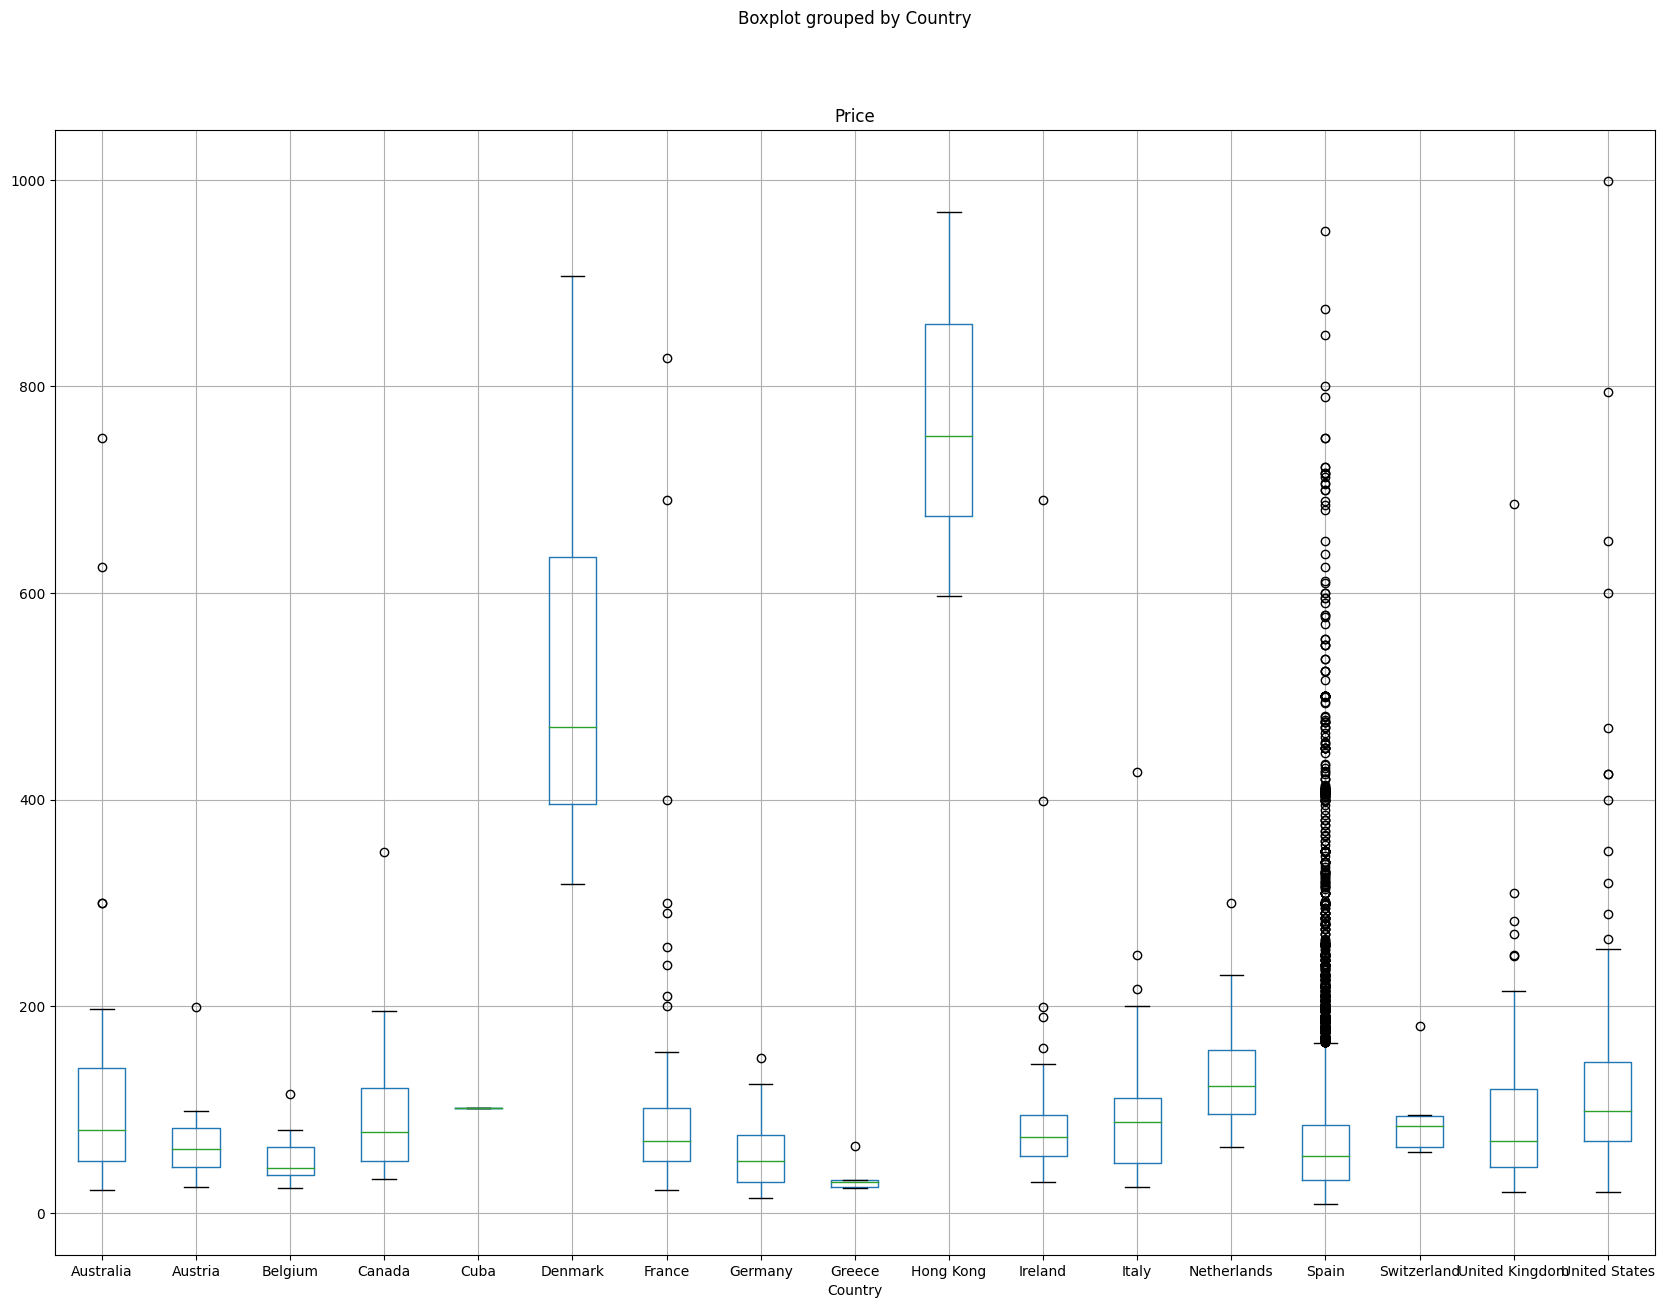

In [ ]:
df.boxplot(by='Country',column = 'Price',figsize=(20, 15))
plt.show()

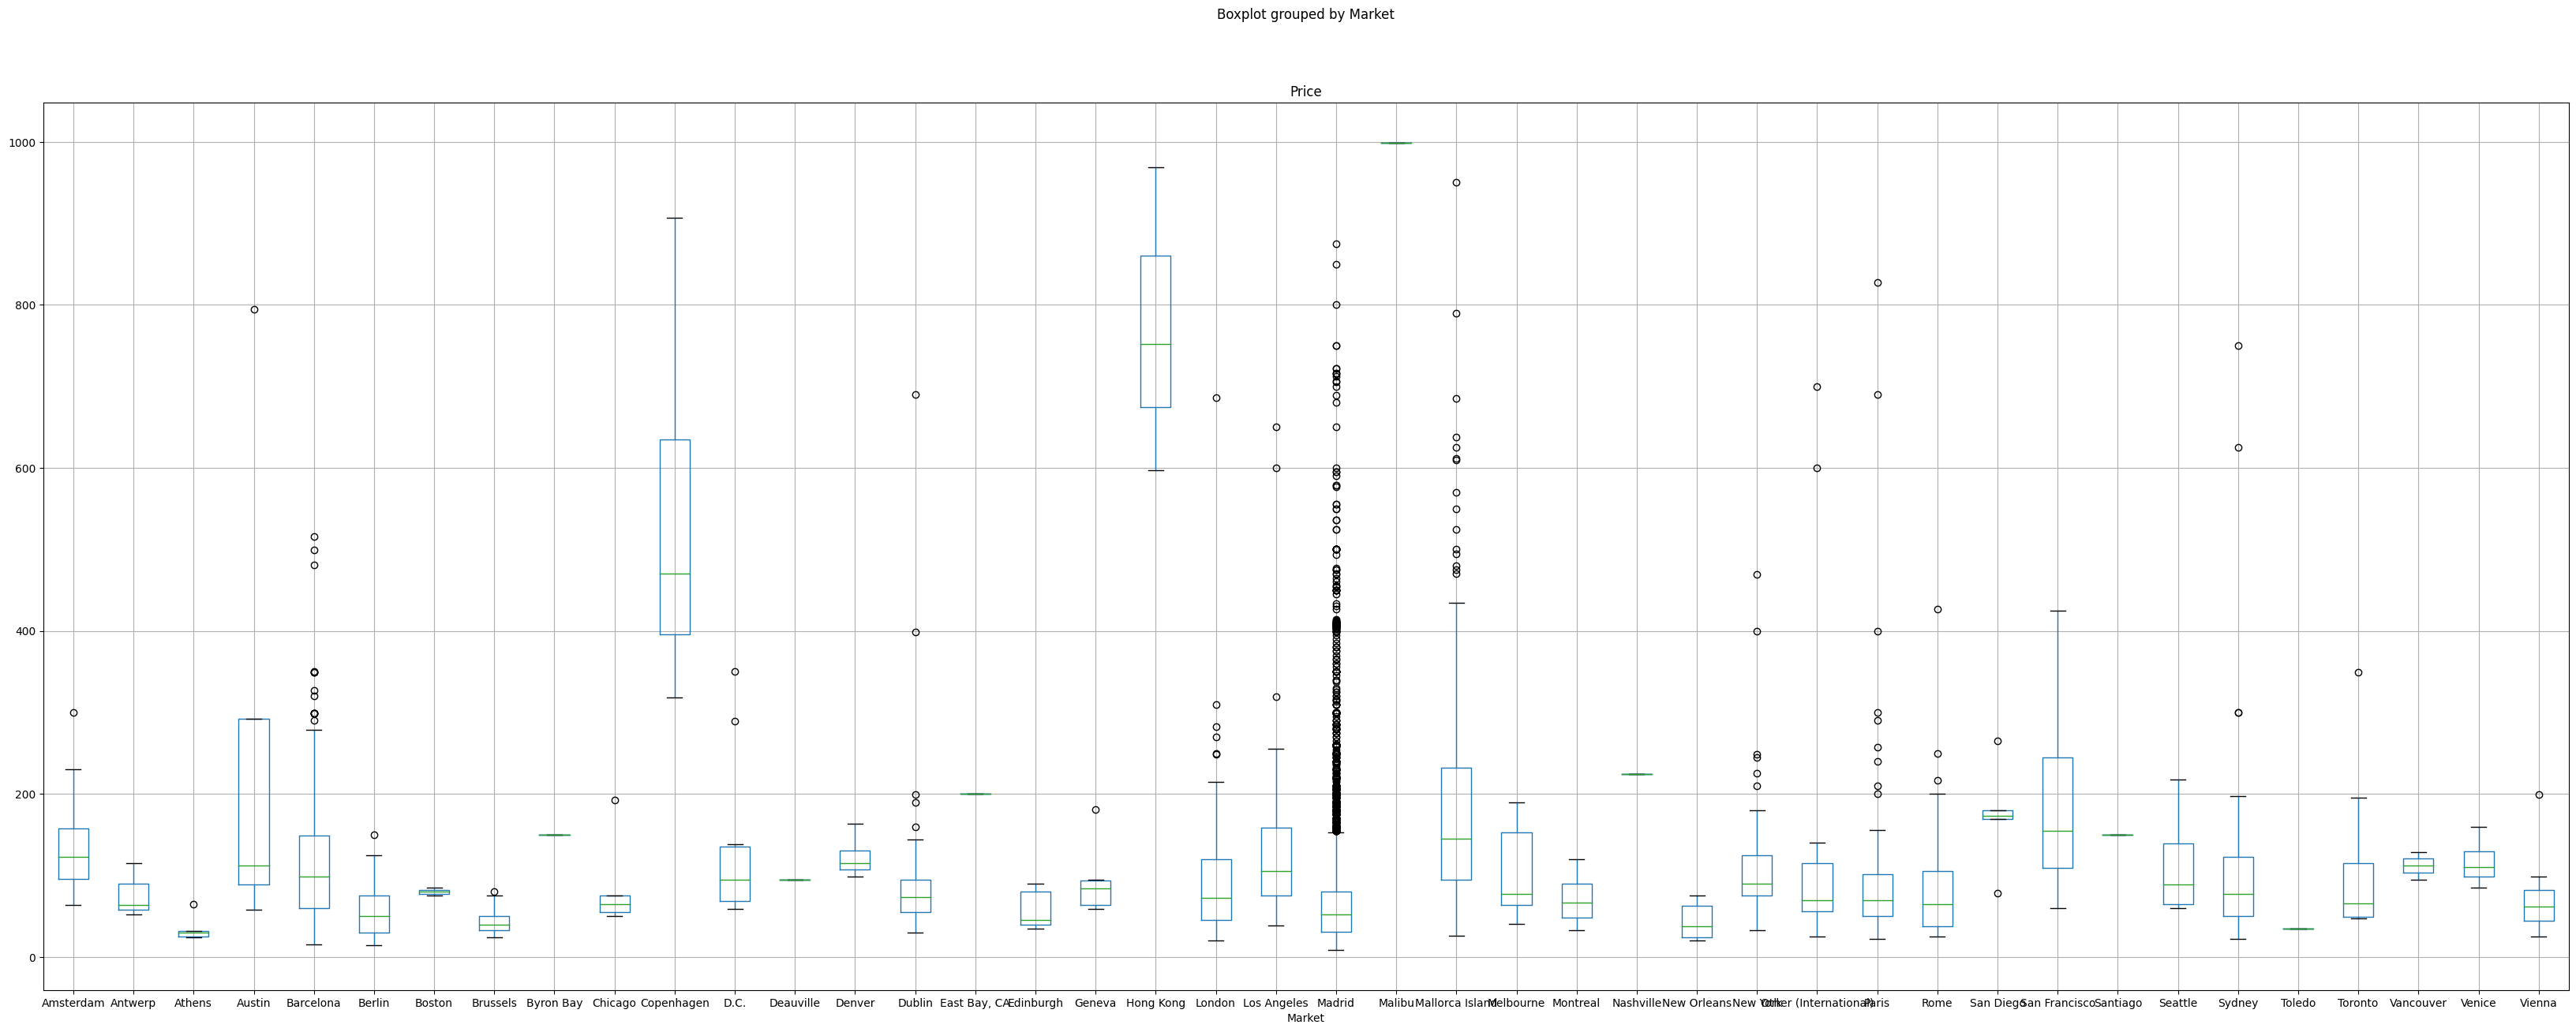

In [ ]:
df.boxplot(by='Market',column = 'Price',figsize=(40, 15))
plt.show()

Razonando como en la variable anterior, nuestros datos estan muy desbalanceados, casi todos con ubicacion en Madrid, España. Ademas viendo los boxplot, vemos que los precios no varian especialmente entre las distintas ubicaciones, por lo que podemos eliminarlas.

In [ ]:
df.drop(['Market','Country'],axis=1,inplace=True)

#### - Property Type

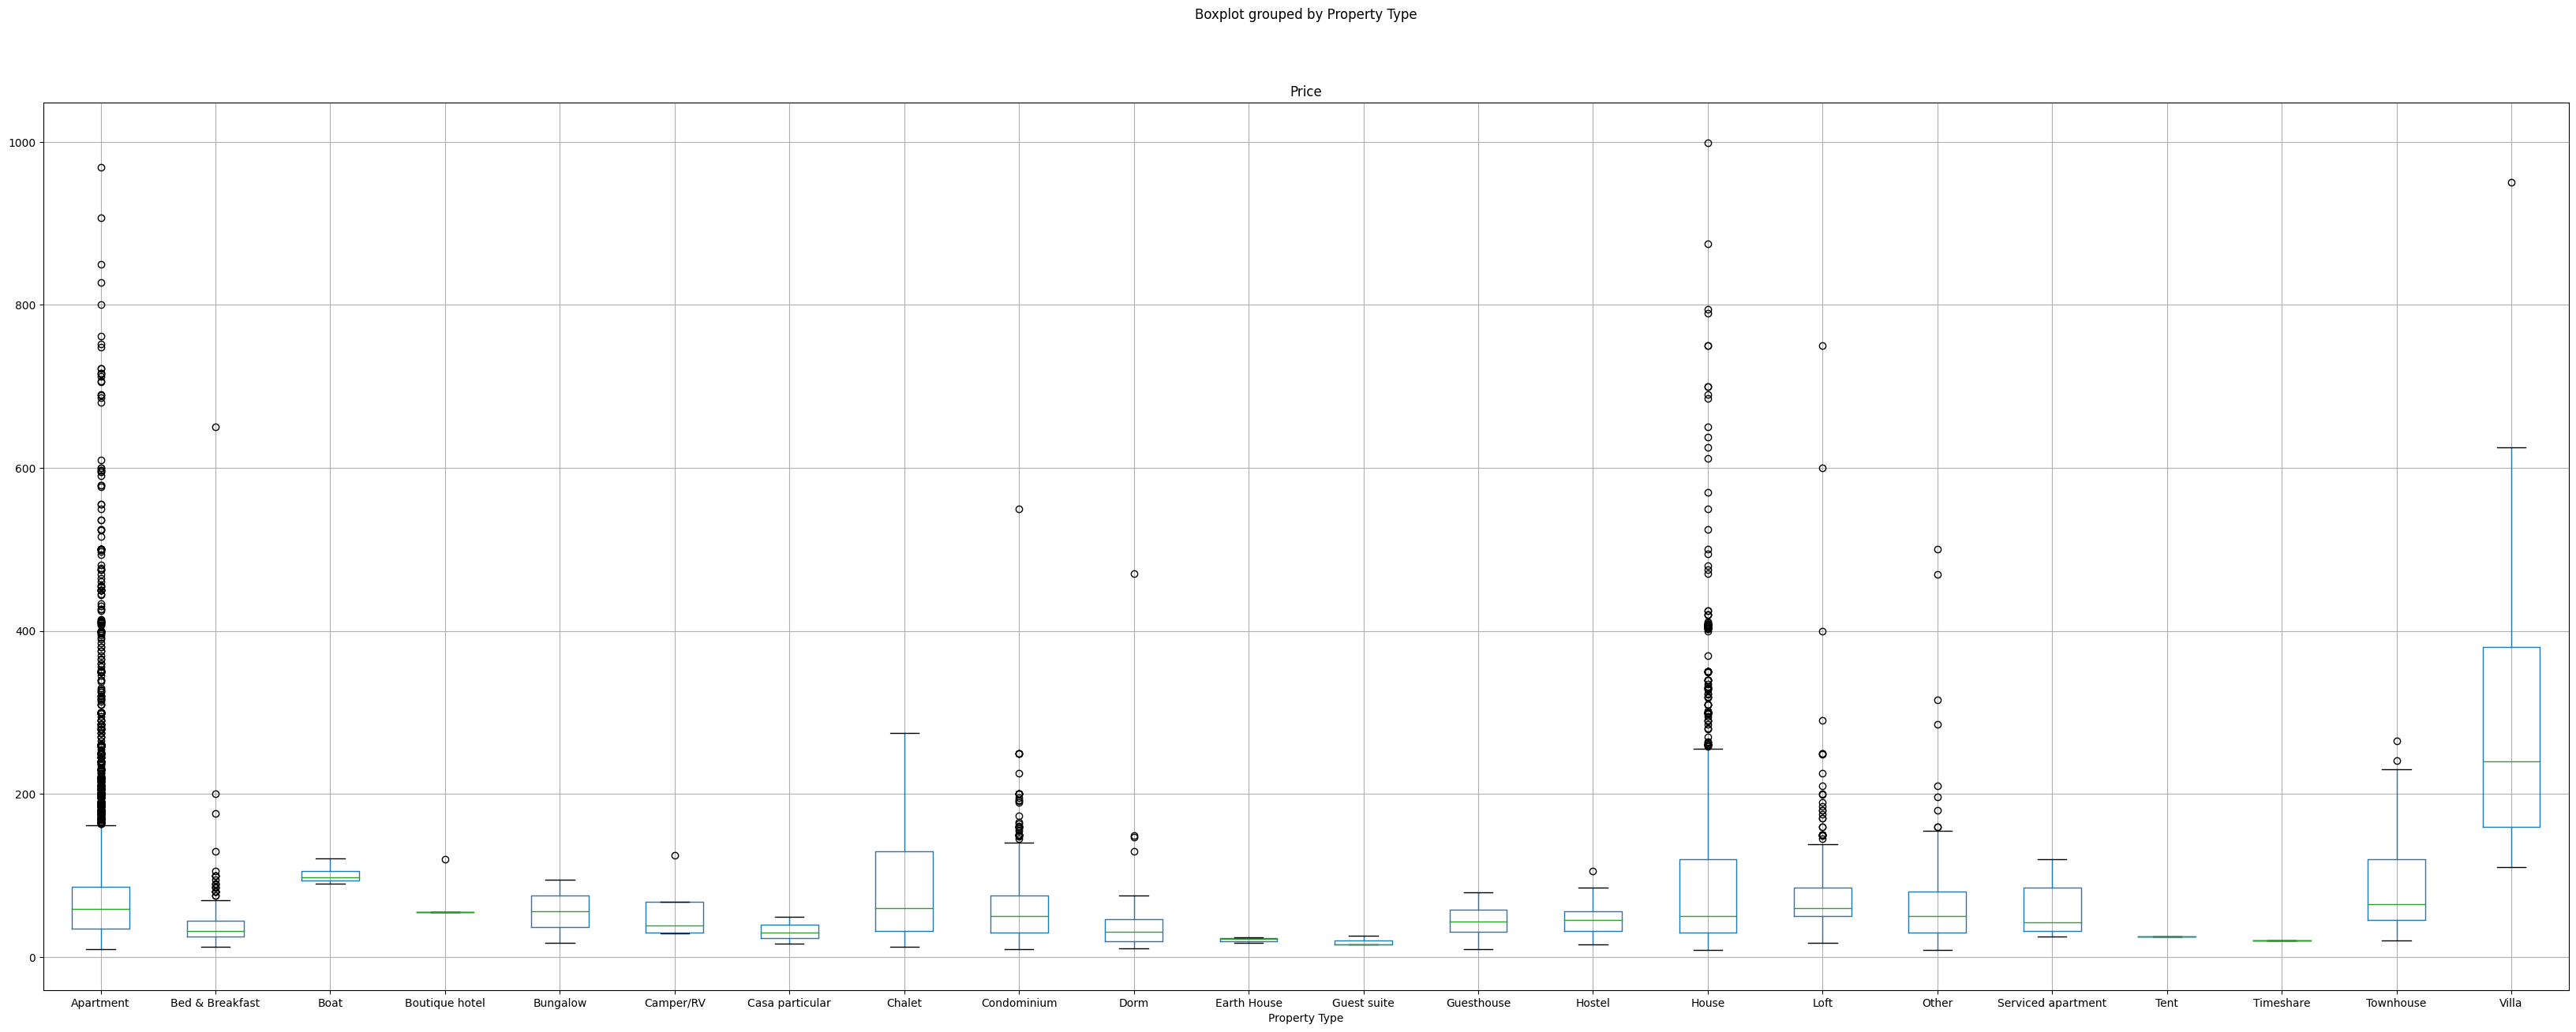

In [ ]:
df.boxplot(by='Property Type',column = 'Price',figsize=(40, 15))
plt.show()

In [ ]:
df['Property Type'].value_counts()

Apartment             11948
House                  1363
Condominium             362
Bed & Breakfast         353
Loft                    304
Other                   225
Dorm                     44
Guesthouse               42
Chalet                   25
Townhouse                17
Villa                    17
Hostel                   16
Serviced apartment       13
Boutique hotel            6
Boat                      4
Camper/RV                 4
Guest suite               3
Casa particular           3
Earth House               3
Bungalow                  2
Tent                      1
Timeshare                 1
Name: Property Type, dtype: int64

Debido a la gran cantidad y diversidad de categorias vamos a usar un label encoder para que asigne a cada categoria un valor entero. Hacemos esto en lugar de un One Hot Encoding porque aumentariamos en exceso la dimension de nuestro dataset 

In [ ]:
# en teoria esto asigna valores en orden alfabetico 
enc = LabelEncoder()
label_encoder = enc.fit(df['Property Type'])
df['Property Type'] = label_encoder.transform(df['Property Type'])

label_dict = {0: 'Apartment', 1: 'Bed & Breakfast ', 2:'Boat',
              3: 'Boutique hotel', 4: 'Bungalow', 5:'Camper/RV',
              6: 'Casa particular', 7: 'Chalet', 8:'Condominium', 9: 'Dorm',
              10: 'Earth House', 11:'Guest suite',12: 'Guesthouse', 
              13: 'Hostel', 14:'House',15: 'Loft', 16: 'Other', 
              17:'Serviced apartment',18: 'Tent', 19: 'Timeshare', 
              20:'Townhouse', 21:'Villa'}

In [ ]:
df['Property Type'].value_counts()

0     11948
14     1363
8       362
1       353
15      304
16      225
9        44
12       42
7        25
20       17
21       17
13       16
17       13
3         6
2         4
5         4
11        3
6         3
10        3
4         2
18        1
19        1
Name: Property Type, dtype: int64

#### - Room Type

In [ ]:
df['Room Type'].value_counts()

Entire home/apt    8959
Private room       5588
Shared room         209
Name: Room Type, dtype: int64

Como tenemos 3 categorias, realizamos One Hot Encoding para crear una columna de ceros o unos para cada una

In [ ]:
#ONE HOT ENCODING PARA 'Payment_of_Min_Amount'
ohe = OneHotEncoder()
oh_array = ohe.fit_transform(df['Room Type'].values.reshape(-1, 1)).toarray()
oh_df = pd.DataFrame(oh_array,columns=['Entire_home_apt','Private_room','Shared_room'])
oh_df

,Entire_home_apt,Private_room,Shared_room
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
14751,1.0,0.0,0.0
14752,0.0,1.0,0.0
14753,1.0,0.0,0.0
14754,1.0,0.0,0.0


In [ ]:
df=df.merge(oh_df,how='left',left_index=True,right_index=True)

In [ ]:
df.drop(['Room Type'],axis=1,inplace=True)

#### - Bed Type

In [ ]:
df['Bed Type'].value_counts()

Real Bed         14432
Pull-out Sofa      258
Futon               42
Couch               19
Airbed               5
Name: Bed Type, dtype: int64

In [ ]:
df['Bed Type'].replace(['Pull-out Sofa','Futon','Couch','Airbed'],'Other',inplace=True)

Operamos de forma analoga al apartado anterior ya que el numero de categorias no es muy grande

In [ ]:
ohe = OneHotEncoder()
oh_array = ohe.fit_transform(df['Bed Type'].values.reshape(-1, 1)).toarray()
oh_df = pd.DataFrame(oh_array,columns=['Other_Bed_Type','Real_Bed'])
oh_df

,Other_Bed_Type,Real_Bed
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
...,...,...
14751,0.0,1.0
14752,0.0,1.0
14753,0.0,1.0
14754,0.0,1.0


In [ ]:
df=df.merge(oh_df,how='left',left_index=True,right_index=True)

In [ ]:
df.drop(['Bed Type'],axis=1,inplace=True)

#### - Calendar Update

Viendo los valores que toma la variable y su significado no creemos que vaya a ser muy relevante en el precio de los airbnb, la eliminamos del analisis

In [ ]:
def calendar_updated(x):
  y = str(x)
  if x == 'today':
    return(x)
  elif x == 'yesterday':
    return('less than one week')
  elif y[2:6] == 'week':
    return('less than one month')
  elif y[2:6] == 'days':
    return('less than one week')
  else:
    return('more than one month')

In [ ]:
df['Calendar Updated']=df['Calendar Updated'].apply(lambda x: calendar_updated(x))
df['Calendar Updated'].value_counts()

less than one month    4197
today                  3923
less than one week     3862
more than one month    2774
Name: Calendar Updated, dtype: int64

In [ ]:
ohe = OneHotEncoder()
oh_array = ohe.fit_transform(df['Calendar Updated'].values.reshape(-1, 1)).toarray()
oh_df = pd.DataFrame(oh_array,columns=['Updated_less_one_month',
                                       'Updated_less_one_week',
                                       'Updated_more_one_month',
                                       'Updated_today'])                           
oh_df

,Updated_less_one_month,Updated_less_one_week,Updated_more_one_month,Updated_today
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
14751,0.0,1.0,0.0,0.0
14752,0.0,1.0,0.0,0.0
14753,0.0,1.0,0.0,0.0
14754,0.0,1.0,0.0,0.0


In [ ]:
df=df.merge(oh_df,how='left',left_index=True,right_index=True)

In [ ]:
df.drop(['Calendar Updated'],axis=1,inplace=True)

In [ ]:
df.head(10)

,Host Since,Host Response Rate,Host Total Listings Count,Latitude,Longitude,Property Type,Accommodates,Bathrooms,Bedrooms,Beds,...,Require Guest Phone Verification,Entire_home_apt,Private_room,Shared_room,Other_Bed_Type,Real_Bed,Updated_less_one_month,Updated_less_one_week,Updated_more_one_month,Updated_today
0,7.0,100.0,1.0,30.337361,-97.863277,15,2,1.0,1.0,1.0,...,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,7.0,100.0,162.0,41.389683,2.172625,0,4,1.0,1.0,1.0,...,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,7.0,100.0,162.0,41.393035,2.162173,0,4,1.0,1.0,1.0,...,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,13.0,100.0,27.0,41.396967,2.167418,0,8,2.0,3.0,4.0,...,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,7.0,99.0,207.0,41.388685,2.155150,0,5,1.0,2.0,2.0,...,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5,7.0,99.0,207.0,41.382537,2.149577,0,6,1.0,2.0,3.0,...,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
6,10.0,100.0,2.0,41.399058,2.184229,0,5,2.0,3.0,4.0,...,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7,11.0,100.0,1.0,41.402357,2.171119,0,2,1.0,1.0,1.0,...,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
8,7.0,99.0,207.0,41.407356,2.182982,0,6,2.0,2.0,3.0,...,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
9,8.0,100.0,1.0,30.287124,-97.768164,14,6,2.0,3.0,3.0,...,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


#### - Cancellation Policy

In [ ]:
df['Cancellation Policy'].value_counts()

strict             5735
flexible           4661
moderate           4241
strict_new           34
super_strict_60      32
moderate_new         20
super_strict_30      19
flexible_new         14
Name: Cancellation Policy, dtype: int64

Con el fin de reducir el numeroi de clases, vamos a transformar la variable para que solo tenga 3 clases: strict, moderate y flexible

In [ ]:
def cat_reduc(x):
  y = x
  if x == 'strict_new':
    y = 'strict'
  elif x == 'super_strict_60':
     y = 'strict'
  elif x == 'super_strict_30':
     y = 'strict'
  elif x == 'moderate_new':
     y = 'moderate'
  elif x == 'flexible_new':
     y = 'flexible'
  else: 
    pass
  return y

In [ ]:
df['Cancellation Policy']=df['Cancellation Policy'].apply(lambda x: cat_reduc(x))
df['Cancellation Policy'].value_counts()

strict      5820
flexible    4675
moderate    4261
Name: Cancellation Policy, dtype: int64

In [ ]:
ohe = OneHotEncoder()
oh_array = ohe.fit_transform(df['Cancellation Policy'].values.reshape(-1, 1)).toarray()
oh_df = pd.DataFrame(oh_array,columns=['flexible','moderate','strict'])
oh_df

,flexible,moderate,strict
0,0.0,1.0,0.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,1.0,0.0,0.0
...,...,...,...
14751,0.0,0.0,1.0
14752,1.0,0.0,0.0
14753,0.0,0.0,1.0
14754,0.0,1.0,0.0


In [ ]:
df=df.merge(oh_df,how='left',left_index=True,right_index=True)

In [ ]:
df.drop(['Cancellation Policy'],axis=1,inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14756 entries, 0 to 14755
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Host Since                        14756 non-null  float64
 1   Host Response Rate                14756 non-null  float64
 2   Host Total Listings Count         14756 non-null  float64
 3   Latitude                          14756 non-null  float64
 4   Longitude                         14756 non-null  float64
 5   Property Type                     14756 non-null  int64  
 6   Accommodates                      14756 non-null  int64  
 7   Bathrooms                         14756 non-null  float64
 8   Bedrooms                          14756 non-null  float64
 9   Beds                              14756 non-null  float64
 10  Price                             14756 non-null  float64
 11  Security Deposit                  14756 non-null  float64
 12  Clea

# 2. Análisis exploratorio

## 2.1 Correlaciones

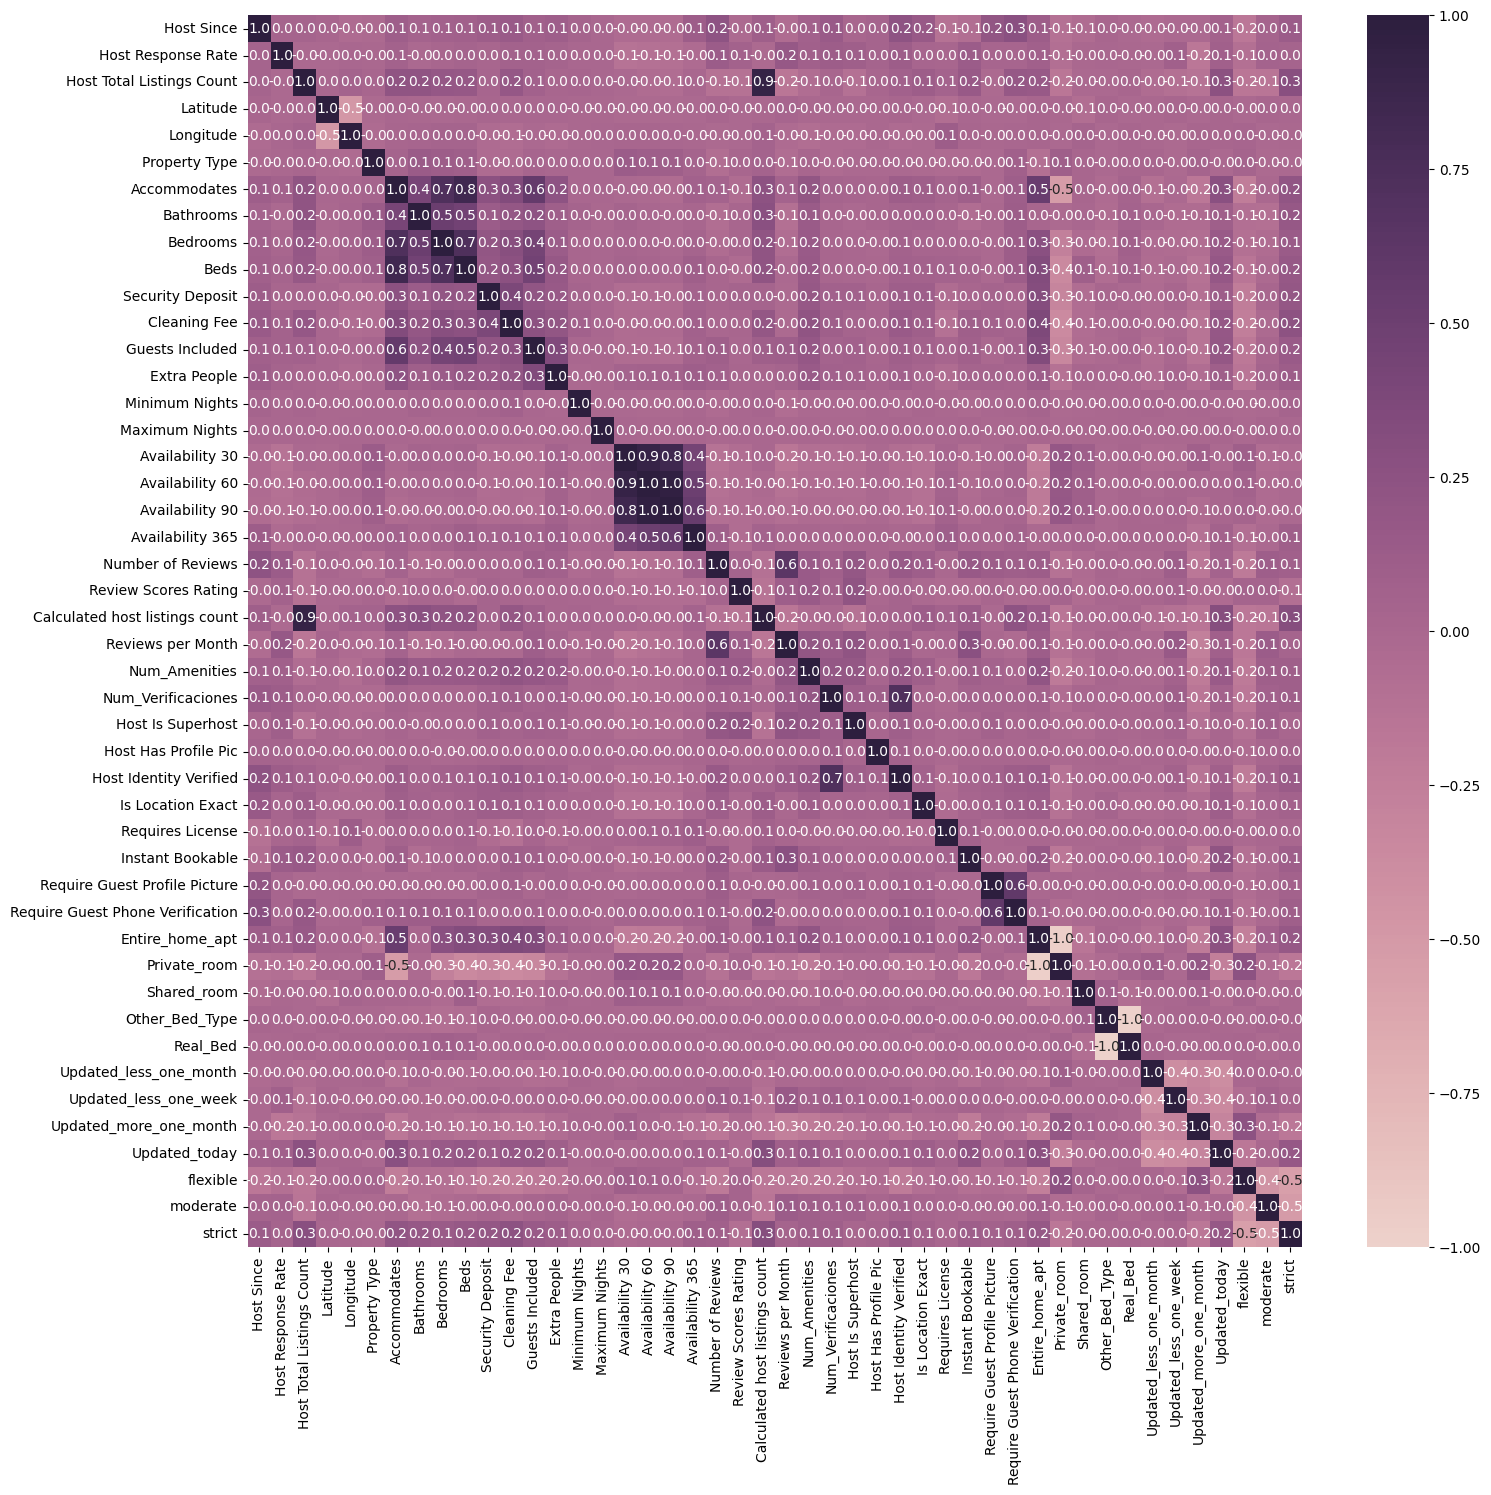

In [ ]:
plt.figure(figsize=(17,16))
correlaciones= df.drop(['Price'], axis=1).corr()
sns.heatmap(correlaciones,cmap=sns.cubehelix_palette(as_cmap=True),annot=True,fmt='.1f')
plt.show()

Podemos ver correlaciones bastante altas entre algunas variables, vamos a comentarlas:

Las variables *Calculated Host Listing Count* y *Host Total Listing Count* tienen un coeficiente de correlación bastante elevado de 0.9, con lo cual eliminaremos una de ellas.
Tambien destacan las correlaciones entre *Entire_home_apt - Private_Room* y *Real_Bed - Other_Bed_Type* que llegan a tomar el valor -1. Eliminaremos una de ellas tambien.

Para elegir cual de ellas eliminamos, miraremos las correlaciones de estas variables con la variable objetivo y eliminaremos la que tenga la correlacion más baja.

Destacan tambien otras correlaciones altas como *Number of reviews - Reviews per month*, *Num_verifications - Host Identity Verified*, *Require guest profile pic - Require guest phone verification* y *Accomodates - Bedrooms - Beds*.
Pese a que son altas, al no ser tan altas como las mencionadas en primer lugar, esperaremos a ver el resto de metodos de seleccion de variables para ver si las eliminamos o no.

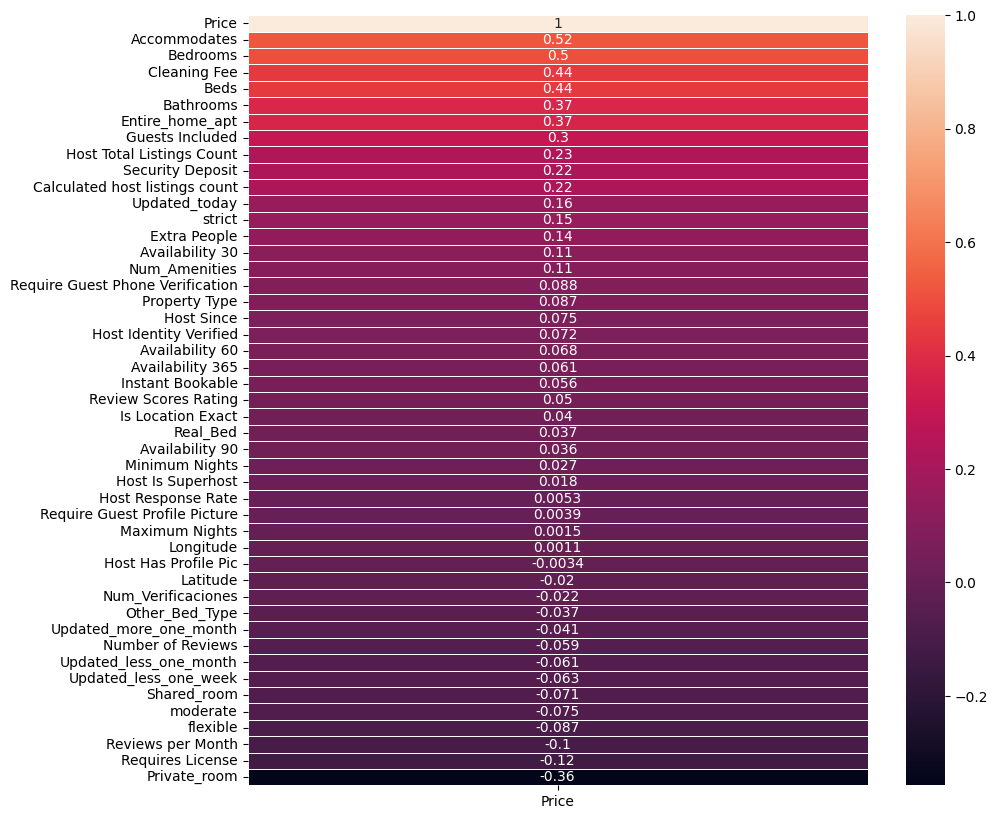

In [ ]:
corr = df.corr()[['Price']].sort_values(by='Price', ascending=False)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True,linewidths=.5, ax=ax)
plt.show()

Las correlaciones de los pares de variables de interes son bastante parecidos (en valor absoluto) por lo que da igual cual eliminemos.

In [ ]:
df.drop(['Calculated host listings count','Private_room','Other_Bed_Type'],axis=1,inplace=True)

## 2.2 Seleccion de Variables

### Métodos Wrapped


In [ ]:
df.columns

Index(['Host Since', 'Host Response Rate', 'Host Total Listings Count',
       'Latitude', 'Longitude', 'Property Type', 'Accommodates', 'Bathrooms',
       'Bedrooms', 'Beds', 'Price', 'Security Deposit', 'Cleaning Fee',
       'Guests Included', 'Extra People', 'Minimum Nights', 'Maximum Nights',
       'Availability 30', 'Availability 60', 'Availability 90',
       'Availability 365', 'Number of Reviews', 'Review Scores Rating',
       'Reviews per Month', 'Num_Amenities', 'Num_Verificaciones',
       'Host Is Superhost', 'Host Has Profile Pic', 'Host Identity Verified',
       'Is Location Exact', 'Requires License', 'Instant Bookable',
       'Require Guest Profile Picture', 'Require Guest Phone Verification',
       'Entire_home_apt', 'Shared_room', 'Real_Bed', 'Updated_less_one_month',
       'Updated_less_one_week', 'Updated_more_one_month', 'Updated_today',
       'flexible', 'moderate', 'strict'],
      dtype='object')

In [ ]:
col_names=['Price','Host Since', 'Host Response Rate', 'Host Total Listings Count',
       'Latitude', 'Longitude', 'Property Type', 'Accommodates', 'Bathrooms',
       'Bedrooms', 'Beds', 'Security Deposit', 'Cleaning Fee',
       'Guests Included', 'Extra People', 'Minimum Nights', 'Maximum Nights',
       'Availability 30', 'Availability 60', 'Availability 90',
       'Availability 365', 'Number of Reviews', 'Review Scores Rating',
       'Reviews per Month', 'Num_Amenities', 'Num_Verificaciones',
       'Host Is Superhost', 'Host Has Profile Pic', 'Host Identity Verified',
       'Is Location Exact', 'Requires License', 'Instant Bookable',
       'Require Guest Profile Picture', 'Require Guest Phone Verification',
       'Entire_home_apt', 'Shared_room', 'Real_Bed', 'Updated_less_one_month',
       'Updated_less_one_week', 'Updated_more_one_month', 'Updated_today',
       'flexible', 'moderate', 'strict']

In [ ]:
df = df.reindex(columns=col_names)

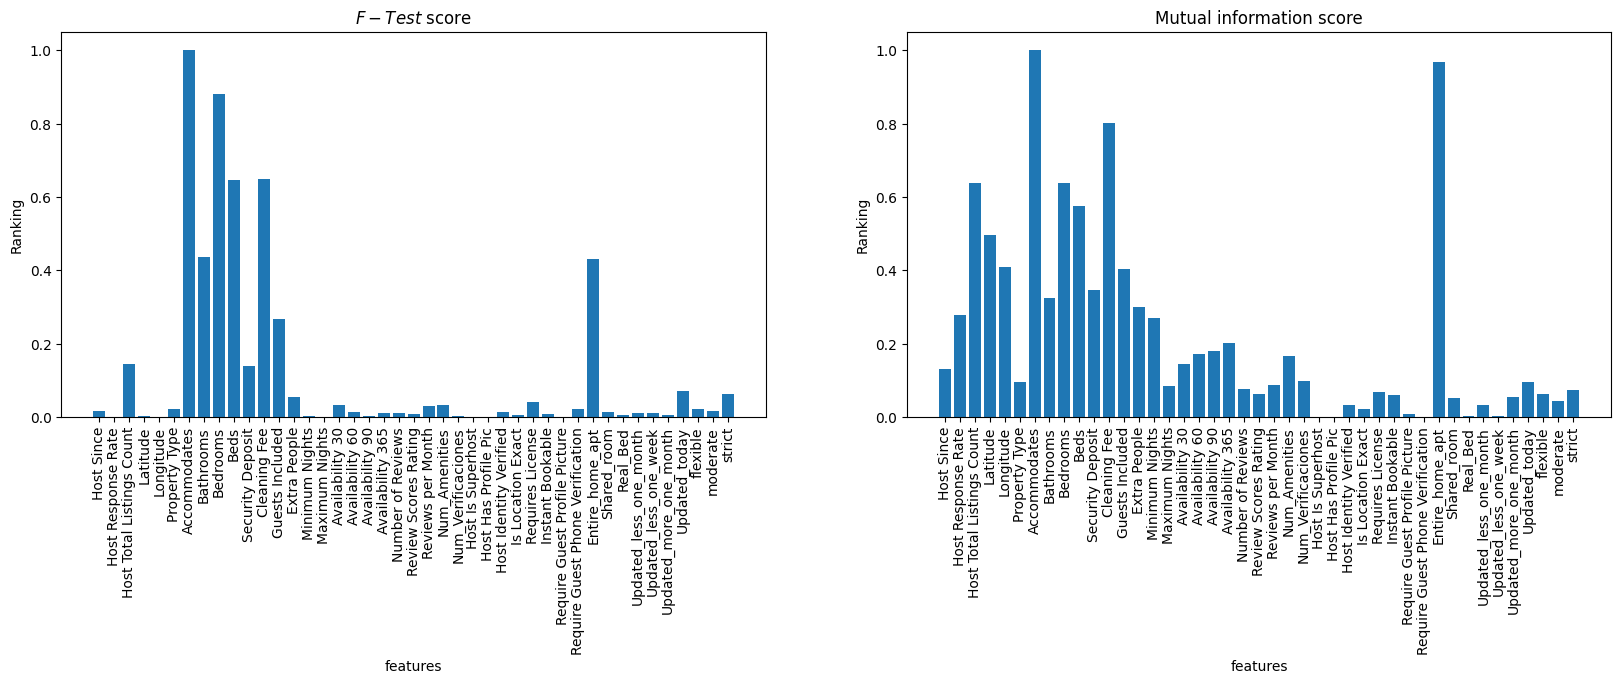

In [ ]:
# convertimos el DataFrame al formato necesario para scikit-learn
data = df.values 

y = data[:,0:1]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = df.columns[1:]


# do calculations
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-Test$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

Podemos observar en el primer gráfico que las variables con mayor influencia sobre la variable objetivo son:

*   Acommodates
*   Bedrooms
*   Beds
*   Cleaning Fee
*   Entire home/apt

Por el contrario, las variables relacionadas con la ubicación, las características referentes al Host y las reseñas no parecen tener gran influencia en el precio de un Airbnb.

En cuanto al segundo gráfico, podemos apreciar que los resutados son bastante similares pero con valores mayores en general. Destaca el aumento de importancia de la variable *Host total Listings Count* respecto a las demás.



### Métodos embedded

Como metodo de seleccion de caracteristicas de tipo embebido utilizaremos la regresion LASSO. La regularización LASSO penaliza la suma del valor absoluto de los coeficientes de regresión, es decir, añadimos a la funcion de costes. 
Esta penalización se conoce como L1 y no solo ayuda a reducir el sobreajuste sino que además nos ayuda a seleccionar caracteristicas haciendo que los coeficientes del modelo tomen el valor 0.

Dado que estos métodos de regularización actúan sobre la magnitud de los coeficientes del modelo, todos deben de estar en la misma escala, por esta razón es necesario estandarizar o normalizar los predictores antes de entrenar el modelo.

In [ ]:
# Dividimos los datos en entrenamiento y test (75 training, 25 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 2)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)
XtestScaled = scaler.transform(X_test)

Datos entrenamiento:  (11067, 43)
Datos test:  (3689, 43)


El grado de penalización está controlado por el hiperparámetro  alfa
 . Cuando  alfa=0
 , el resultado es equivalente al de un modelo lineal por mínimos cuadrados ordinarios. A medida que  alfa
  aumenta, mayor es la penalización y más predictores quedan excluidos. A continuación buscaremos un valor óptimo para este parámetro:

best mean cross-validation score: -2904.694
best parameters: {'alpha': 0.18329807108324336}


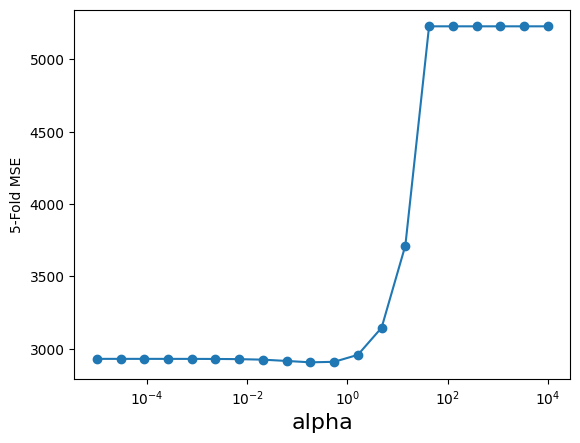

In [ ]:
alpha_vector = np.logspace(-5,4,20)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

In [ ]:
alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

MSE Modelo Lasso (train): 2.86e+03
MSE Modelo Lasso (test) : 2.49e+03
RMSE Modelo Lasso (train): 53.5
RMSE Modelo Lasso (test) : 49.9
Host Since -1.6167067708798608
Host Response Rate 0.23284393218457153
Host Total Listings Count 3.8020591462728963
Latitude -1.965835381268297
Longitude -0.04653110379306284
Property Type 1.6391111995345597
Accommodates 15.648685997284531
Bathrooms 11.419047714800929
Bedrooms 10.721203291217364
Beds -2.383979384517716
Security Deposit -0.5181656136799042
Cleaning Fee 15.827945376772993
Guests Included -0.6719922217007028
Extra People 0.4041674460154226
Minimum Nights -0.03417780320430787
Maximum Nights -0.0
Availability 30 13.616470185181777
Availability 60 -0.0
Availability 90 -3.3115648807410287
Availability 365 -0.5580205709008669
Number of Reviews 0.0
Review Scores Rating 5.378924040024095
Reviews per Month -4.6553436265526695
Num_Amenities -2.628112818989658
Num_Verificaciones -5.363956096600365
Host Is Superhost 2.1518049685745426
Host Has Profile 

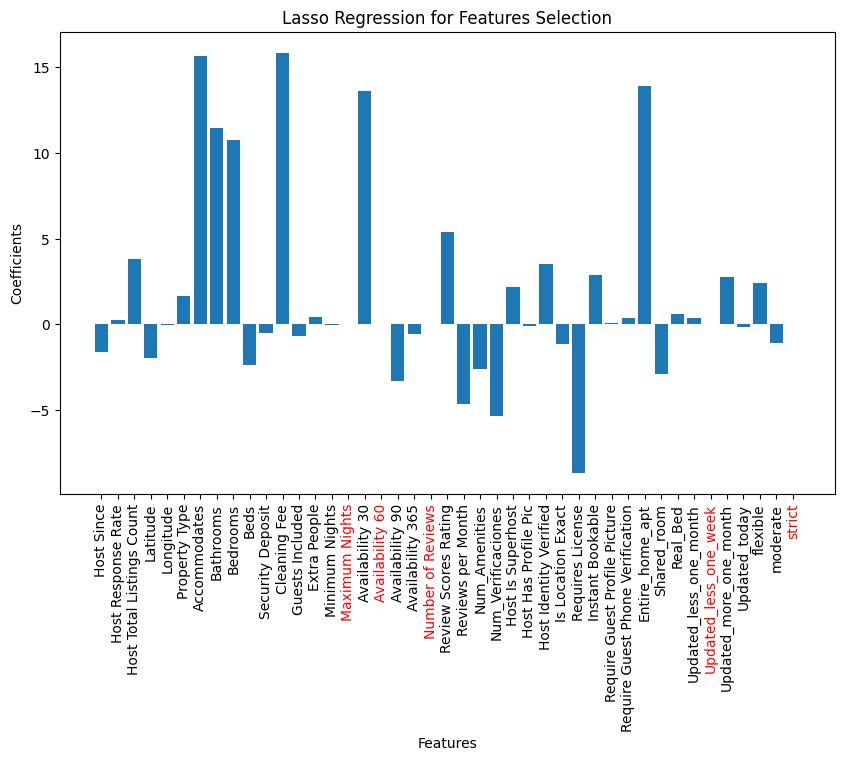

In [ ]:
plt.figure(figsize=(10,6))
ax = plt.gca()
plt.bar([x for x in range(len(w))], w,align="center")
plt.xticks(range(len(w)),feature_names, rotation = 90)
labels = ax.get_xticklabels()
for label, wi in zip(labels, w):
  if wi == 0:
    label.set_color('r')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Lasso Regression for Features Selection')
plt.show()

Las variables que tienen coeficiente 0 son :

*   Maximum nights
*   Number of reviews
*   Availability 60
*   Updated_less_one_week 
*   strict 

Estas variables presentan también en el gráfico F-test score un valor nulo. En mutual information score tienen un valor mayor, pero en comparción con el resto de variables es bastante bajo. 

Con estos resultados, vamos a eliminar las siguientes variables



In [ ]:
df.drop(['Maximum Nights','Number of Reviews','Availability 60','Updated_less_one_week', 'strict'],axis=1,inplace=True)

In [ ]:
df

,Price,Host Since,Host Response Rate,Host Total Listings Count,Latitude,Longitude,Property Type,Accommodates,Bathrooms,Bedrooms,...,Require Guest Profile Picture,Require Guest Phone Verification,Entire_home_apt,Shared_room,Real_Bed,Updated_less_one_month,Updated_more_one_month,Updated_today,flexible,moderate
0,58.0,7.0,100.000000,1.0,30.337361,-97.863277,15,2,1.0,1.0,...,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,70.0,7.0,100.000000,162.0,41.389683,2.172625,0,4,1.0,1.0,...,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,70.0,7.0,100.000000,162.0,41.393035,2.162173,0,4,1.0,1.0,...,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,229.0,13.0,100.000000,27.0,41.396967,2.167418,0,8,2.0,3.0,...,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,149.0,7.0,99.000000,207.0,41.388685,2.155150,0,5,1.0,2.0,...,0,0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14751,90.0,10.0,100.000000,1.0,40.678945,-73.939342,0,2,1.0,1.0,...,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
14752,75.0,6.0,94.845885,1.0,48.836197,2.294045,1,1,1.0,1.0,...,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
14753,100.0,8.0,100.000000,1.0,48.888809,2.316173,0,5,1.0,2.0,...,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
14754,99.0,10.0,100.000000,1.0,39.742205,-104.959933,0,4,1.0,1.0,...,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## 2.3 Distribucion de los datos

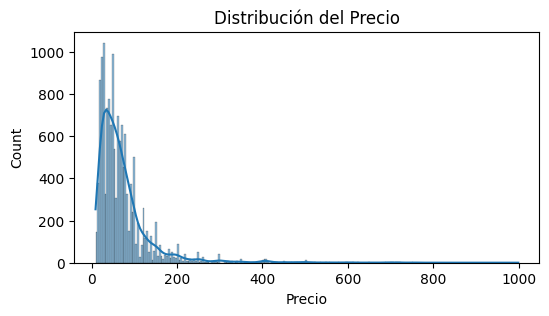

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
sns.histplot(data=df, x='Price', kde=True,ax=ax)
ax.set_title("Distribución del Precio")
ax.set_xlabel('Precio');

In [ ]:
df['Price'].describe()

count    14756.000000
mean        73.578138
std         72.072894
min          9.000000
25%         34.000000
50%         55.000000
75%         86.000000
max        999.000000
Name: Price, dtype: float64

Podemos observar que el precio más comun ronda entre los 34 y los 86 euros, llegando a un maximo de 999 euros.

(0.6294593811035156, 0.0)


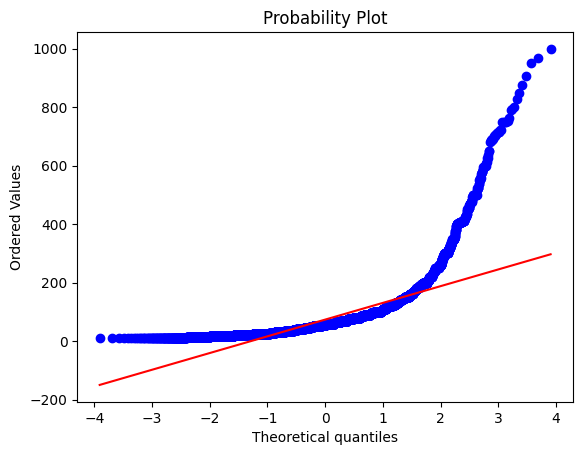

In [ ]:
stat, p =shapiro(df['Price'])
print((stat,p))
ss.probplot(df['Price'],dist='norm',plot=pylab)
pylab.show()

Claramente la la variable objetivo no sigue una distribucion normal.

## 2.4 Outliers

Vamos a eliminar las observaciones que sean outlier en multiples columnas simultaneamente.

In [ ]:
def find_outliers_IQR(df): #La funcion devuelve 1 si es outlier y 0 si no lo es
  outliers=[]

  q1=df.quantile(0.25)
  q3=df.quantile(0.75)
  IQR=q3 - q1
  Vi=q1-1.5*IQR
  Vs=q3+1.5*IQR

  for i in range(len(df)):
    if df[i]<Vi:
      outliers.append(1)
    elif df[i]>Vs:
      outliers.append(1)
    else:
      outliers.append(0)

  return  outliers

In [ ]:
#almacena todas las observaciones que tienen outliers en nuevo dataframe
outliers_df=pd.DataFrame(columns=df.columns[1:]) 
for i in df.columns[1:]:
  outliers_df[i]=find_outliers_IQR(df[i])
outliers_df['Suma']=outliers_df.sum(axis=1)  

In [ ]:
print('Si eliminamos las observaciones que son outliers en más de' ,
      outliers_df.Suma.quantile(0.90),
      'variables eliminamos el 10% del dataset')
print('Si eliminamos las observaciones que son outliers en más de' ,
      outliers_df.Suma.quantile(0.95),
      'variables eliminamos el 5% del dataset')
print('Si eliminamos las observaciones que son outliers en más de' ,
      outliers_df.Suma.quantile(0.99),
      'variables eliminamos el 1% del dataset')

Si eliminamos las observaciones que son outliers en más de 4.0 variables eliminamos el 10% del dataset
Si eliminamos las observaciones que son outliers en más de 5.0 variables eliminamos el 5% del dataset
Si eliminamos las observaciones que son outliers en más de 9.0 variables eliminamos el 1% del dataset


In [ ]:
outliers_df[outliers_df['Suma'] >= 4]

,Host Since,Host Response Rate,Host Total Listings Count,Latitude,Longitude,Property Type,Accommodates,Bathrooms,Bedrooms,Beds,...,Require Guest Phone Verification,Entire_home_apt,Shared_room,Real_Bed,Updated_less_one_month,Updated_more_one_month,Updated_today,flexible,moderate,Suma
0,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,1,1,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,8
6,0,0,0,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14750,0,0,0,1,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,7
14751,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
14752,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
14753,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [ ]:
df.drop(outliers_df[outliers_df['Suma'] >= 4].index,axis=0,inplace=True) #Quitamos los outliers multivariantes
df.reset_index(drop=True,inplace=True) #Reajustamos los indices

Tras esto acabaria la primera fase del trabajo, y nos quedaria esta base de datos para trabajar la fase 2, la seleccion y ajuste de los distintos modelos.

In [ ]:
df

,Price,Host Since,Host Response Rate,Host Total Listings Count,Latitude,Longitude,Property Type,Accommodates,Bathrooms,Bedrooms,...,Require Guest Profile Picture,Require Guest Phone Verification,Entire_home_apt,Shared_room,Real_Bed,Updated_less_one_month,Updated_more_one_month,Updated_today,flexible,moderate
0,149.0,7.0,99.000000,207.0,41.388685,2.155150,0,5,1.0,2.0,...,0,0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,106.0,7.0,99.000000,207.0,41.382537,2.149577,0,6,1.0,2.0,...,0,0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,45.0,11.0,100.000000,1.0,41.402357,2.171119,0,2,1.0,1.0,...,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,100.0,8.0,100.000000,1.0,52.366679,4.865595,0,2,1.0,1.0,...,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,115.0,10.0,90.000000,1.0,41.381369,2.180874,0,3,2.0,1.0,...,0,0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12330,25.0,7.0,83.000000,4.0,40.385395,-3.669958,8,7,1.0,2.0,...,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
12331,50.0,7.0,100.000000,4.0,40.405239,-3.638197,0,6,1.0,3.0,...,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
12332,16.0,8.0,60.000000,2.0,40.408779,-3.650200,0,1,1.0,1.0,...,0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
12333,120.0,10.0,94.845885,2.0,39.896533,3.076243,0,6,1.0,2.0,...,0,0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
path='/content/drive/MyDrive/airbnb-listings-extract-limpio.csv'
df.to_csv(path,sep=';',index=True)